# Needed libraries

In [4]:
from numpy.random import normal
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
colorsss = ['royalblue', 'gold' , 'green', 'purple',  'cyan']
import sys
from tqdm import tqdm

from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from scipy import ndimage
from scipy.stats import binned_statistic_2d
import pickle

import pandas as pd
import seaborn as sns

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import astropy.units as u
from scipy.stats import ks_2samp,cramervonmises_2samp
from time import time
from matplotlib.lines import Line2D
from collections import Counter


In [7]:
module_path = 'demeter/'
sys.path.append(module_path)
import demeter 

In [8]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye
from EagleEye import S_SB_estimate_X_overdensities
from EagleEye import S_SB_estimate_Y_overdensities
from utils_EE import compute_the_null, partitioning_function

In [9]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


# Custom Functions

In [10]:
def run_demeter(full_field_gno, random_field_gno):
    grid_size = 96
    edge_size = 6
    front = int(edge_size)
    back  = int(grid_size-edge_size)

    random_image, edges = demeter.make_field_image(random_field_gno, gnomonic_width, pmfield_size, grid_size)
    field_image, edges = demeter.make_field_image(full_field_gno, gnomonic_width, pmfield_size, grid_size)

    smooth_field = scipy.ndimage.gaussian_filter(field_image,3.0)
    
    wv = demeter.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5']).to(device)
    out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
    rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

    #apply smoothing 
    out = scipy.ndimage.gaussian_filter(out,3.0)
    rand_out = scipy.ndimage.gaussian_filter(rand_out,3.0)

    #remove outer edges of image 
    out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
    out1[front:back,front:back,front:back,front:back] = 1
    out1 = out*out1

    #standardize the real output 
    out = (out-np.mean(rand_out))/np.std(rand_out)

    #apply threshold 
    edge_size = 6
    front = int(edge_size)
    back = int(grid_size-edge_size)
    nstars = len(data)
    
    #apply significance correction 
    out = out / (-0.6*np.log10(nstars)+4.)
    
    #applying thresholding 
    mask = out < 5.0 
    out[mask] = 0
    
    #remove outer edges of image
    out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
    out1[front:back,front:back,front:back,front:back] = 1
    out1 = out*out1

    #find remaining hotspots 
    blobs, significance = demeter.find_blobs(out1, threshold=9)

    #find clusters in original dataset 
    clusters_demeter = demeter.find_clusters(data_dwarf, x_dwarf, y_dwarf, gnomonic_width, pmfield_size, grid_size, blobs)

    return blobs, significance, clusters_demeter

In [11]:
def S_rootB_estimate(dict,repechage_EE_book):
    over_clusters  = repechage_EE_book["Y_OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['Repechaged'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['Background'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['Pruned'] for idx in list(over_clusters.keys())]))
    #n2             =  len(dict['stats']['mixed_samples']) 
    #n1             =  len(dict['stats']['reference_samples'])
    n2             =  len(dict['Upsilon_i_X'])
    n1             =  len(dict['Upsilon_i_Y'])
    SoUpsilons     =  np.concatenate([dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']] for idx in list(over_clusters.keys())])

    under_clusters =  repechage_EE_book["X_OVER_clusters"]
    lenWu          =  len(np.concatenate([under_clusters[idx]['Pruned'] for idx in list(under_clusters.keys())]))
    S_B = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu) )
    S_B = S_B / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))
    S_B = {'Total' : S_B}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['Repechaged'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['Background'])
        lenWo          =  len(over_clusters[idx]['Pruned'])
        S_B[idx] = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu))
        S_B[idx] = S_B[idx] / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))
        Upsilon_xi[idx] = min(dict['Upsilon_i_Y'][over_clusters[idx]['Repechaged']])
    return S_B,Upsilon_xi

In [12]:
def download_gaia(l=90, b=30, size = 2, delta_l = None, delta_b = None):
    Gaia.ROW_LIMIT = -1  # Ensure the default row limit.

    # Let's download a field
    coord = SkyCoord(l=l, b=b, unit=(u.degree, u.degree), frame='galactic')
    j = Gaia.query_object_async(coord, width=u.Quantity(size, u.deg), height=u.Quantity(size, u.deg))

    parallax = np.asarray(j['parallax'])
    parallax_error = np.asarray(j['parallax_error'])
    Gmag = np.asarray(j['phot_g_mean_mag'])
    logg = np.asarray(j['logg_gspphot_lower'])
    nss = np.asarray(j['non_single_star'])
    qso = np.asarray(j['in_qso_candidates'])
    glx = np.asarray(j['in_galaxy_candidates'])
    andr = np.asarray(j['in_andromeda_survey'])
    ruwe = np.asarray(j['ruwe'])
    
    eq_coords = SkyCoord( ra  = j['ra'], dec = j['dec'], pm_ra_cosdec =  j['pmra'], pm_dec = j['pmdec'], frame = 'icrs')

    galactic_coords = eq_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
        
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)

    ind = np.where( (Gmag < 20) &
                ((parallax - 3 * parallax_error) > 0.) & # From data paper
                (logg > 4) &
                (nss == 0) &
                (qso == False) &
                (glx == False) &
                (andr == False) &
                (np.abs(pmlat_full) < 5) &
                (np.abs(pmlon_full) < 5) &
                (ruwe < 1.4) )[0]
    
    data = np.vstack((glon_full[ind], glat_full[ind], pmlon_full[ind], pmlat_full[ind])).T

    if delta_l is not None: data[:,0] = data[:,0] + delta_l
    if delta_b is not None: data[:,1] = data[:,1] + delta_b
    return data

In [13]:
n_jobs =10
def analyze_gaia(l=90, b=30, size = 2, norm = True, add_gaussian = False, ndwarf = 20):
    start = time()
    # Download the field that will be studied
    data = download_gaia(l=l, b=b, size = size)

    if add_gaussian:        
        #generate mock data 
        xx_dwarf = normal(loc = data[:,0].mean() * (1 + 0.0002), scale = size/20, size = ndwarf)
        yy_dwarf = normal(loc = data[:,1].mean() * (1 - 0.0002), scale = size/20, size = ndwarf)
        pmra = normal(loc = data[:,2].mean() * (1 + 0.5), scale = 5/20, size = ndwarf)
        pmdec = normal(loc = data[:,3].mean() * (1 + 0.5), scale = 5/20, size = ndwarf)
        data = np.vstack((data, np.c_[xx_dwarf, yy_dwarf, pmra, pmdec]))

    print(f'Analizing a {size}°x{size}° patch of sky center at (l,b) = {(l,b)}, with {len(data)} stars...')
    K_M = int(0.15 * len(data)) # We look for anomalies up to 15% the total number of stars in the field

    aux_data = np.copy(data)
    if norm:
        aux_data = (aux_data - np.min(data, axis = 0)) / (np.max(data, axis = 0) - np.min(data, axis = 0)) 
        
    # Download the references around the field
    references = []
    references.append( download_gaia(l=l+size, b=b     , size = size, delta_l = -size, delta_b = None) )
    print(f'Adding ref with {len(references[0])} stars')
    
    references.append( download_gaia(l=l+size, b=b+size, size = size, delta_l = -size, delta_b = -size) )
    print(f'Adding ref with {len(references[1])} stars')
    
    references.append( download_gaia(l=l     , b=b+size, size = size, delta_l = None , delta_b = -size) )
    print(f'Adding ref with {len(references[2])} stars')
    
    references.append( download_gaia(l=l-size, b=b+size, size = size, delta_l = size , delta_b = -size) )
    print(f'Adding ref with {len(references[3])} stars')
    
    references.append( download_gaia(l=l-size, b=b     , size = size, delta_l = size , delta_b = None) )
    print(f'Adding ref with {len(references[4])} stars')
    
    references.append( download_gaia(l=l-size, b=b-size, size = size, delta_l = size , delta_b = size) )
    print(f'Adding ref with {len(references[5])} stars')
    
    references.append( download_gaia(l=l     , b=b-size, size = size, delta_l = None , delta_b = size) )
    print(f'Adding ref with {len(references[6])} stars')
    
    references.append( download_gaia(l=l+size, b=b-size, size = size, delta_l = -size , delta_b = size) )
    print(f'Adding ref with {len(references[7])} stars')
    # --------------------------------------------------------------------------------------------

    # Begin calls to EagleEye
    aux_results_random = []
    aux_results = []
    aux_clusters = []
    aux_books = []
    aux_results_pos = []
    aux_clusters_pos = []
    aux_books_pos = []
    aux_results_vel = []
    aux_clusters_vel = []
    aux_books_vel = []
    bad_analysis = []
    for iref, ref in enumerate(references):
        
        aux_ref = np.copy(ref)
        if norm: aux_ref = (aux_ref - np.min(data, axis = 0)) / (np.max(data, axis = 0) - np.min(data, axis = 0)) 
        
        p = len(aux_data)/(len(aux_data)+len(aux_ref))
        p_ext = 1e-5
        
        stats_null = compute_the_null(p=p, K_M=K_M)
        try:
            result_dictionary, stats_null = EagleEye.Soar(aux_ref, aux_data, K_M=K_M, p_ext=p_ext, n_jobs=n_jobs, 
                                          stats_null=stats_null, result_dict_in={})
            result_dictionary_pos, stats_null_pos = EagleEye.Soar(aux_ref[:,:2], aux_data[:,:2], K_M=K_M, p_ext=p_ext, n_jobs=n_jobs, 
                                          stats_null=stats_null, result_dict_in={})
            result_dictionary_vel, stats_null_vel = EagleEye.Soar(aux_ref[:,2:], aux_data[:,2:], K_M=K_M, p_ext=p_ext, n_jobs=n_jobs, 
                                          stats_null=stats_null, result_dict_in={})
        except:
            print(f'EE fails at (l,b) = {l,b}')
            bad_analysis.append((l,b))
            result_dictionary = {}
            result_dictionary_pos = {}
            result_dictionary_vel = {}

        result_dictionary['nstars'] = len(aux_data)
        result_dictionary['nref'] = len(aux_ref)
        result_dictionary['glat'] = l
        result_dictionary['glon'] = b    
        try:
            clusters = partitioning_function(aux_ref, aux_data, result_dictionary, p_ext=p_ext, Z=2.65 )
            EE_book = EagleEye.Repechage(aux_ref, aux_data, result_dictionary, clusters, p_ext=p_ext)
            clusters_pos = partitioning_function(aux_ref[:,:2], aux_data[:,:2], result_dictionary_pos, p_ext=p_ext, Z=2.65 )
            EE_book_pos = EagleEye.Repechage(aux_ref[:,:2], aux_data[:,:2], result_dictionary_pos, clusters, p_ext=p_ext)
            clusters_vel = partitioning_function(aux_ref[:,2:], aux_data[:,2:], result_dictionary_vel, p_ext=p_ext, Z=2.65 )
            EE_book_vel = EagleEye.Repechage(aux_ref[:,2:], aux_data[:,2:], result_dictionary_vel, clusters, p_ext=p_ext)

        except:
            clusters = []
            EE_book = []
            clusters_pos = []
            EE_book_pos = []
            clusters_vel = []
            EE_book_vel = []
            print(f'Clustering fails at (l,b) = {l,b} reference {iref}')                    
            bad_analysis.append((l,b,iref))
            
        aux_clusters.append(clusters)
        aux_books.append(EE_book)
        aux_results.append(result_dictionary)
        aux_clusters_pos.append(clusters_pos)
        aux_books_pos.append(EE_book_pos)
        aux_results_pos.append(result_dictionary_pos)
        aux_clusters_vel.append(clusters_vel)
        aux_books_vel.append(EE_book_vel)
        aux_results_vel.append(result_dictionary_vel)
    
    stop = time()
    print(f'It took {(stop-start)/3600} hs to analizing a {size}°x{size}° patch of sky center at (l,b) = {(l,b)}, with {len(data)} stars...')
    return data, references, aux_results, aux_clusters, aux_books, aux_results_pos, aux_clusters_pos, aux_books_pos, aux_results_vel, aux_clusters_vel, aux_books_vel

# Gaia first try

In [9]:
#gaia_data, references, results, clusters, books, results_pos, clusters_pos, books_pos, results_vel, clusters_vel, books_vel = analyze_gaia(l=289, b=33.5, size = 2, add_gaussian=True, ndwarf=15)

In [8]:
#xx_dwarf = normal(loc = gaia_data[:,0].mean() * (1 + 0.002), scale = size/20, size = ndwarf)
#yy_dwarf = normal(loc = gaia_data[:,1].mean() * (1 + 0.002), scale = size/20, size = ndwarf)
#pmra = normal(loc = gaia_data[:,2].mean() * (1 + 0.5), scale = 5/20, size = ndwarf)
#pmdec = normal(loc = gaia_data[:,3].mean() * (1 + 0.5), scale = 5/20, size = ndwarf)

In [9]:
#gaia_data[:,0].mean()

In [10]:
#plt.scatter(gaia_data[:,2], gaia_data[:,3])
#plt.scatter(pmra, pmdec)

In [698]:
gaia_data_pd = pd.DataFrame(gaia_data, columns=['ra','dec','pmra','pmdec'])

In [678]:
gaia_x, gaia_y = demeter.to_gnomonic(gaia_data[:,0],gaia_data[:,1],gaia_data[:,0].mean(), gaia_data[:,1].mean())

In [679]:
gaia_data_gno = np.c_[gaia_x, gaia_y, gaia_data[:,2], gaia_data[:,3]]

(array([3.02e-01, 1.70e-01, 4.38e-02, 9.80e-03, 1.66e-03, 3.33e-04,
        4.70e-05, 8.44e-06, 5.28e-07, 1.06e-06]),
 array([9.76e-04, 1.90e+00, 3.79e+00, 5.69e+00, 7.58e+00, 9.48e+00,
        1.14e+01, 1.33e+01, 1.52e+01, 1.71e+01, 1.90e+01]),
 [<matplotlib.patches.Polygon at 0x7f635491d280>])

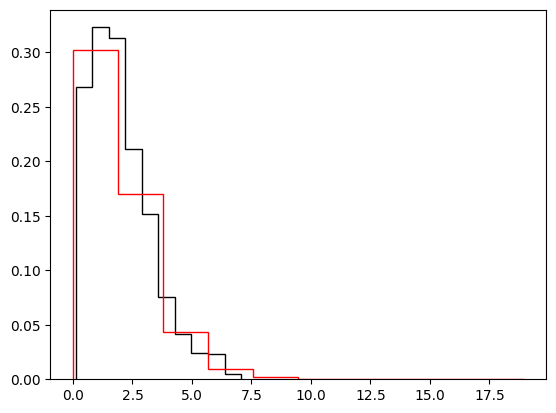

In [848]:
plt.hist(results_vel[2]['Upsilon_i_Y'], color = 'black', histtype = 'step', density = True)
plt.hist(results_vel[2]['stats_null'][list(results_vel[2]['stats_null'].keys())[0]], color = 'red', histtype = 'step', density = True)

In [851]:
ind

array([], dtype=int64)

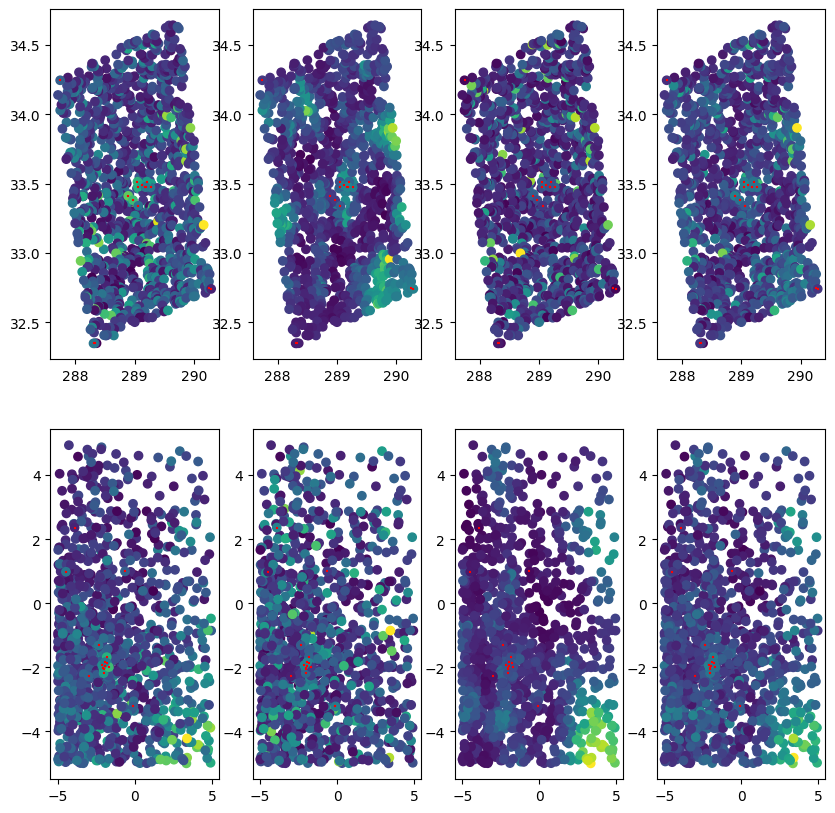

In [858]:
iref = 7
fig,ax = plt.subplots(2,4, figsize = (10,10))

ax[0,0].scatter(gaia_data[:,0], gaia_data[:,1], c = results[iref]['Upsilon_i_Y'])
ax[0,0].scatter(gaia_data[-15:,0], gaia_data[-15:,1], marker = '+', color = 'red', s = 2)
up_th = results[iref]['stats_null'][list(results[iref]['stats_null'].keys())[0]].max()
ind = np.where(results[iref]['Upsilon_i_Y'] > up_th)[0]
if len(ind) > 0:
    ax[0,0].scatter(gaia_data[ind,0], gaia_data[ind,1], color = 'red', facecolor = 'none')
    ax[1,0].scatter(gaia_data[ind,2], gaia_data[ind,3], color = 'red', facecolor = 'none')

ax[0,1].scatter(gaia_data[:,0], gaia_data[:,1], c = results_pos[iref]['Upsilon_i_Y'])
ax[0,1].scatter(gaia_data[-15:,0], gaia_data[-15:,1], marker = '+', color = 'red', s = 2)
up_th = results_pos[iref]['stats_null'][list(results_pos[iref]['stats_null'].keys())[0]].max()
ind = np.where(results_pos[iref]['Upsilon_i_Y'] > up_th)[0]
if len(ind) > 0:
    ax[0,1].scatter(gaia_data[ind,0], gaia_data[ind,1], color = 'red', facecolor = 'none')
    ax[1,1].scatter(gaia_data[ind,2], gaia_data[ind,3], color = 'red', facecolor = 'none')

ax[0,2].scatter(gaia_data[:,0], gaia_data[:,1], c = results_vel[iref]['Upsilon_i_Y'])
ax[0,2].scatter(gaia_data[-15:,0], gaia_data[-15:,1], marker = '+', color = 'red', s = 2)
up_th = results_vel[iref]['stats_null'][list(results_vel[iref]['stats_null'].keys())[0]].max()
ind = np.where(results_vel[iref]['Upsilon_i_Y'] > up_th)[0]
if len(ind) > 0:
    ax[0,2].scatter(gaia_data[ind,0], gaia_data[ind,1], color = 'red', facecolor = 'none')
    ax[1,2].scatter(gaia_data[ind,2], gaia_data[ind,3], color = 'red', facecolor = 'none')

ax[0,3].scatter(gaia_data[:,0], gaia_data[:,1], c = (results[iref]['Upsilon_i_Y'] + results_pos[iref]['Upsilon_i_Y'] + results_vel[iref]['Upsilon_i_Y']) / 3)
ax[0,3].scatter(gaia_data[-15:,0], gaia_data[-15:,1], marker = '+', color = 'red', s = 2)
up_th = results[iref]['stats_null'][list(results[iref]['stats_null'].keys())[0]] + results_pos[iref]['stats_null'][list(results_pos[iref]['stats_null'].keys())[0]] + results_vel[iref]['stats_null'][list(results_vel[iref]['stats_null'].keys())[0]]
ind = np.where(results[iref]['Upsilon_i_Y'] > up_th.max())[0]
if len(ind) > 0:
    ax[0,3].scatter(gaia_data[ind,0], gaia_data[ind,1], color = 'red', facecolor = 'none')
    ax[1,3].scatter(gaia_data[ind,2], gaia_data[ind,3], color = 'red', facecolor = 'none')

ax[1,0].scatter(gaia_data[:,2], gaia_data[:,3], c = results[iref]['Upsilon_i_Y'])
ax[1,0].scatter(gaia_data[-15:,2], gaia_data[-15:,3], marker = '+', color = 'red', s = 2)

ax[1,1].scatter(gaia_data[:,2], gaia_data[:,3], c = results_pos[iref]['Upsilon_i_Y'])
ax[1,1].scatter(gaia_data[-15:,2], gaia_data[-15:,3], marker = '+', color = 'red', s = 2)

ax[1,2].scatter(gaia_data[:,2], gaia_data[:,3], c = results_vel[iref]['Upsilon_i_Y'])
ax[1,2].scatter(gaia_data[-15:,2], gaia_data[-15:,3], marker = '+', color = 'red', s = 2)

ax[1,3].scatter(gaia_data[:,2], gaia_data[:,3], c = (results[iref]['Upsilon_i_Y'] + results_pos[iref]['Upsilon_i_Y'] + results_vel[iref]['Upsilon_i_Y']) / 3)
ax[1,3].scatter(gaia_data[-15:,2], gaia_data[-15:,3], marker = '+', color = 'red', s = 2)

# Data generation

In [14]:
#test function to load gaia data -- reset median_ra and median_dec to
#test values around edges of survey 
#set parameters 
grid_size = 96
edge_size = 6
front = int(edge_size)
back  = int(grid_size-edge_size)

#center of the sky field in RA and DEC 
median_ra  = 2.5
median_dec = 0


#width of the field in gnomonic coordinates 
gnomonic_width = 0.0175

#width of the proper motion field 
pmfield_size = 5.0 

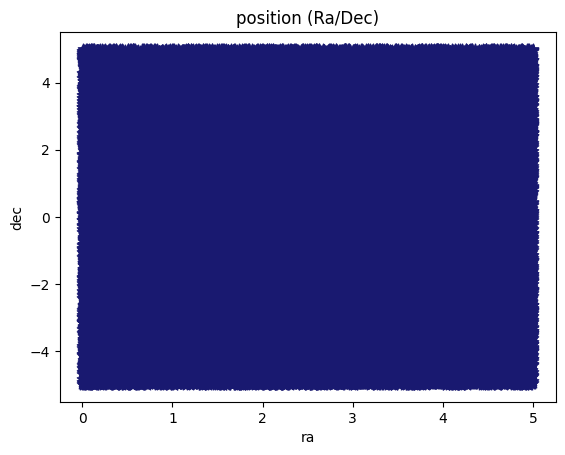

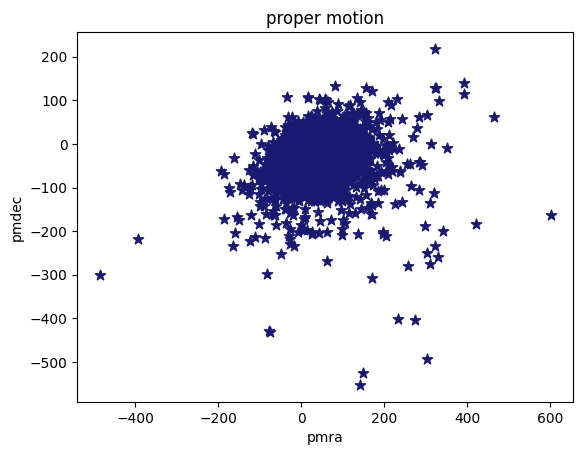

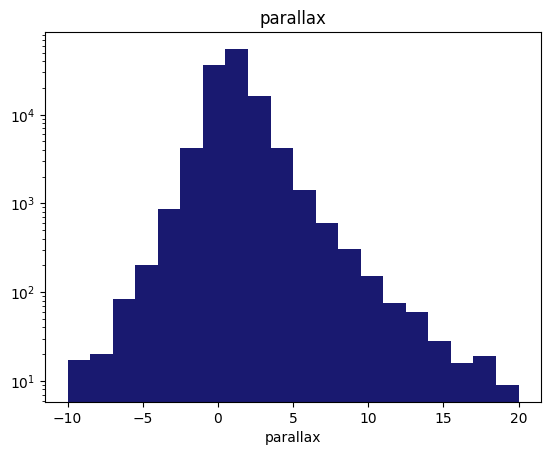

In [15]:
#load example gaia data and plot distributions 

data = pd.read_csv('demeter/data/gaia_example_data.csv')

plt.scatter(data['ra'], data['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('position (Ra/Dec)')

plt.show()

plt.scatter(data['pmra'], data['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.title('proper motion')

plt.show()

parallax = data['parallax']

plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
plt.yscale('log')
plt.xlabel('parallax')
plt.title('parallax')

plt.show()



In [16]:
data = data.drop(['pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'g_rp','bp_g', 'bp_rp', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
                  'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                  'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error'], axis=1)


In [17]:
data.columns

Index(['Unnamed: 0', 'source_id', 'dec', 'ra', 'pmra', 'pmdec', 'parallax',
       'parallax_error'],
      dtype='object')

In [18]:
len(data)

119968

In [19]:
#apply position, proper motion, and parallax cuts 
#data_ref_cut = data 
data, x_ref, y_ref = demeter.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)
ref_field = np.c_[x_ref, y_ref, data['pmra'], data['pmdec']]


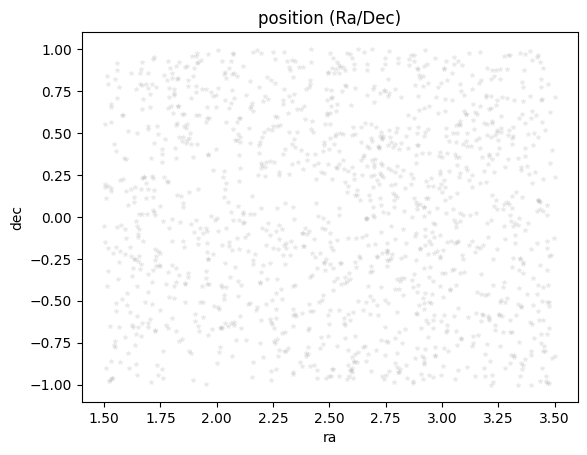

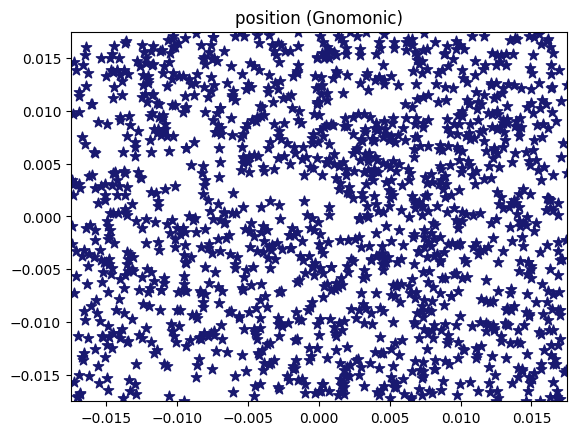

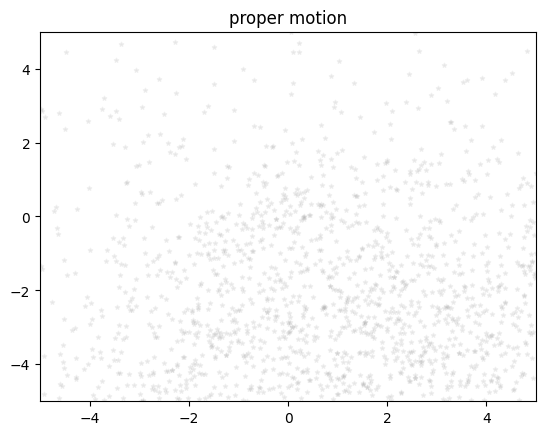

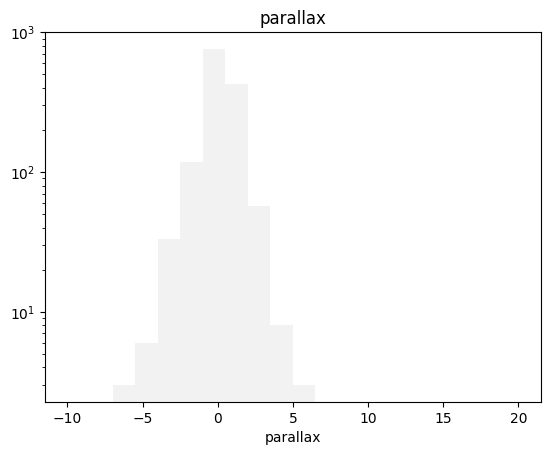

In [20]:
#check masking and gnomonic projection 
plt.scatter(data['ra'], data['dec'], c='grey',alpha=0.1, s=10,marker='*')
#%plt.scatter(data_ref_cut['ra'], data_ref_cut['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('position (Ra/Dec)')
plt.show()


plt.scatter(x_ref,y_ref, c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position (Gnomonic)')


plt.show()
plt.scatter(data['pmra'], data['pmdec'], c='grey',alpha=0.1, s=10,marker='*')
#%plt.scatter(data_ref_cut['pmra'], data_ref_cut['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlim([-pmfield_size,pmfield_size])
plt.ylim([-pmfield_size,pmfield_size])
plt.title('proper motion')

plt.show()

parallax = data['parallax']
plt.hist(data['parallax'], bins = 20, range=(-10, 20), color='grey',alpha=0.1)
#%plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
plt.yscale('log')
plt.xlabel('parallax')
plt.title('parallax')

plt.show()

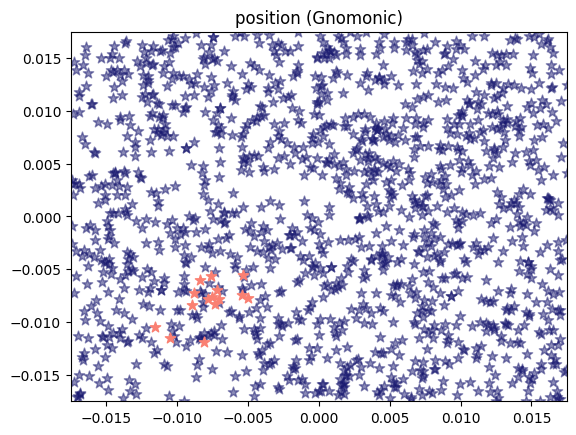

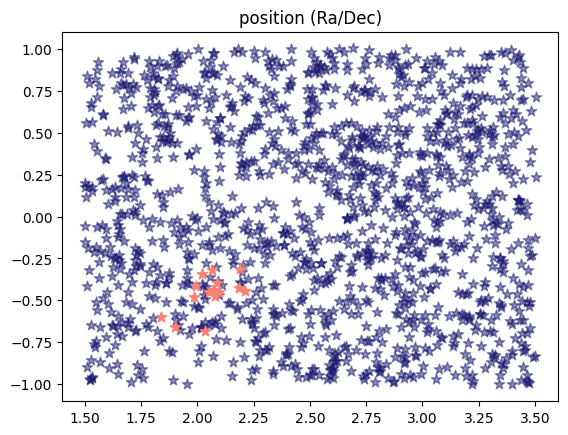

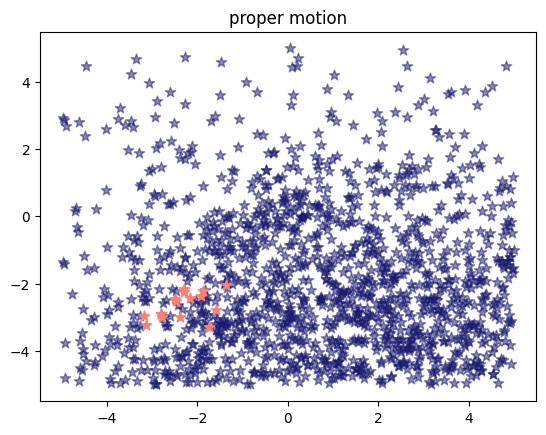

In [21]:
#test pipeline for simple gaussian "mock injection" 

ndwarf = 15
sigma_ang = gnomonic_width/10
sigma_vel = pmfield_size/10
#generate mock data 
xx_dwarf = normal(loc = -gnomonic_width/2, scale = sigma_ang, size = ndwarf)
yy_dwarf = normal(loc = -gnomonic_width/2, scale = sigma_ang, size = ndwarf)
pmra = normal(loc = -pmfield_size/2, scale = sigma_vel, size = ndwarf)
pmdec = normal(loc = -pmfield_size/2, scale = sigma_vel, size = ndwarf)

#xx = np.concatenate([xx, normal(loc = gnomonic_width/2, scale = gnomonic_width/20, size = 20)])
#yy = np.concatenate([yy, normal(loc = gnomonic_width/2, scale = gnomonic_width/20, size = 20)])
#pmra = np.concatenate([pmra, normal(loc = pmfield_size/2, scale = pmfield_size/20, size = 20)])
#pmdec = np.concatenate([pmdec, normal(loc = pmfield_size/2, scale = pmfield_size/20, size = 20)])

plt.scatter(x_ref,y_ref, c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(xx_dwarf,yy_dwarf, c='salmon',alpha=1.,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position (Gnomonic)')

plt.show()

#transform data to Ra/Dec  
ra_inj, dec_inj = demeter.from_gnomonic(xx_dwarf ,yy_dwarf ,median_ra,median_dec)
plt.scatter(data['ra'],data['dec'],c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(ra_inj, dec_inj, c='salmon',alpha=1.,marker='*',s=60)
plt.title('position (Ra/Dec)')

plt.show()

plt.scatter(data['pmra'],data['pmdec'],c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(pmra, pmdec,  c='salmon',alpha=1.,marker='*',s=60)
plt.title('proper motion')

plt.show()

In [22]:
#inject stars into Gaia data and re-apply masking 
dwarf = pd.DataFrame(columns=data.keys())
for k in (data.keys()):
    dwarf[k] = np.ones(len(xx_dwarf))
dwarf['pmra']  = pmra
dwarf['pmdec'] = pmdec
dwarf['ra']    = ra_inj
dwarf['dec']   = dec_inj

data_dwarf = pd.concat([data, dwarf], axis = 0)

data_dwarf, x_dwarf, y_dwarf = demeter.mask_data(data_dwarf, median_ra, median_dec, gnomonic_width, pmfield_size)
full_field = np.c_[data_dwarf['ra'], data_dwarf['dec'], data_dwarf['pmra'], data_dwarf['pmdec']]
full_field_gno = np.c_[x_dwarf, y_dwarf, data_dwarf['pmra'], data_dwarf['pmdec']]

data_bkg, x_bkg, y_bkg = demeter.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)
bkg_field = np.c_[data_bkg['ra'], data_bkg['dec'], data_bkg['pmra'], data_bkg['pmdec']]
bkg_field_gno = np.c_[x_bkg, y_bkg, data_bkg['pmra'], data_bkg['pmdec']]

In [20]:
#%rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(gaia_data_pd, gaia_x, gaia_y, gnomonic_width, pmfield_size)
#%random_field_gno = np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]

In [30]:
#generate random comparison field 

#generate random field 
references = []
for i in range(8):
    for j in range(2):
        rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(data, x_ref, y_ref, gnomonic_width, pmfield_size)
        rand_ra, rand_dec = demeter.from_gnomonic(rand_x ,rand_y ,median_ra,median_dec)
        random_field_aux = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]
        random_field_gno_aux = np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]
        if j == 0:
            random_field = random_field_aux
            random_field_gno = random_field_gno_aux
        else:
            random_field = np.vstack((random_field,random_field_aux))
            random_field_gno = np.vstack((random_field_gno,random_field_gno_aux))
    references.append(random_field)


#%plt.scatter(rand_ra, rand_dec,c='midnightblue',alpha=.5,marker='*',s=60)
#%plt.xlim([-gnomonic_width,gnomonic_width])
#%plt.ylim([-gnomonic_width,gnomonic_width])
#%plt.title('position random field (gnomonic)')

#%plt.show()

#%plt.scatter(rand_pmra, rand_pmdec,c='midnightblue',alpha=.5,marker='*',s=60)

#%plt.title('proper motion random field ')
#%plt.xlim([-pmfield_size,pmfield_size])
#%plt.ylim([-pmfield_size,pmfield_size])
#%plt.show()


In [22]:
random_field = np.zeros_like(full_field)
random_field[:,0] = np.random.uniform(full_field[:,0].min(), full_field[:,0].max(), size = len(full_field))
random_field[:,1] = np.random.uniform(full_field[:,1].min(), full_field[:,1].max(), size = len(full_field))
random_field[:,2] = np.random.uniform(full_field[:,2].min(), full_field[:,2].max(), size = len(full_field))
random_field[:,3] = np.random.uniform(full_field[:,3].min(), full_field[:,3].max(), size = len(full_field))
references.append(random_field)

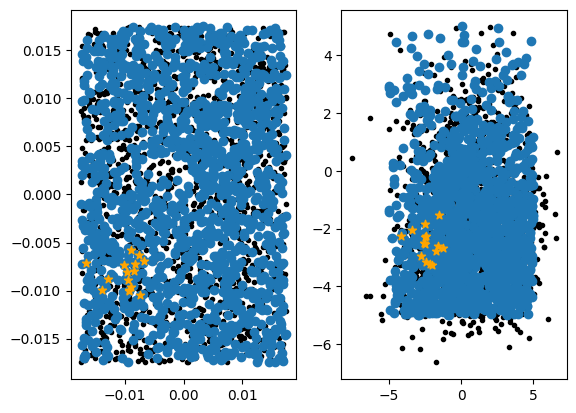

In [23]:
fig,ax = plt.subplots(1,2)

ax[0].scatter(random_field_gno[:,0], random_field_gno[:,1], marker = '.', c = 'black')
ax[0].scatter(full_field_gno[:,0], full_field_gno[:,1])
ax[0].scatter(full_field_gno[-len(dwarf):,0], full_field_gno[-len(dwarf):,1], marker = '*', color = 'orange')

ax[1].scatter(random_field_gno[:,2], random_field_gno[:,3], marker = '.', c = 'black')
ax[1].scatter(full_field_gno[:,2], full_field_gno[:,3])
ax[1].scatter(full_field_gno[-len(dwarf):,2], full_field_gno[-len(dwarf):,3], marker = '*', color = 'orange')

# Demeter

In [169]:
#full_field_gno = gaia_data_gno

In [170]:
#generate histograms for wavelet transformation 

#generate histograms 
random_image, edges = demeter.make_field_image(random_field_gno, gnomonic_width, pmfield_size, grid_size)
field_image, edges = demeter.make_field_image(full_field_gno, gnomonic_width, pmfield_size, grid_size)

print(random_image.shape)

#plt.imshow(field_image.sum(axis=(0,1)), origin='upper')
#plt.show()
#plt.imshow(random_image.sum(axis=(0,1)), origin='upper')
#plt.show()

(96, 96, 96, 96)


In [171]:
#plot smoothed field before transformation 
smooth_field = scipy.ndimage.gaussian_filter(field_image,3.0)

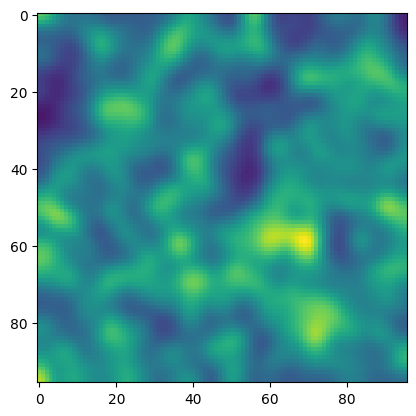

In [172]:
plt.imshow(smooth_field.sum(axis=(2,3))/np.max(smooth_field.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()


In [173]:
#run wavelet function on real and random field 


wv = demeter.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5']).to(device)
out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

cuda


In [174]:
#apply smoothing 
out = scipy.ndimage.gaussian_filter(out,3.0)
rand_out = scipy.ndimage.gaussian_filter(rand_out,3.0)

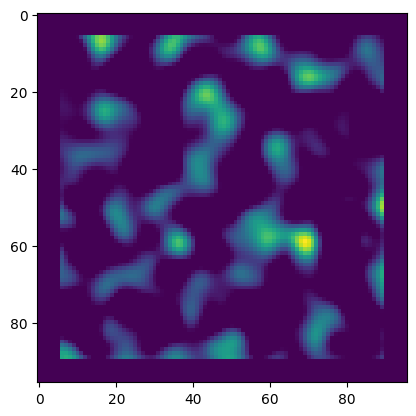

In [175]:
#remove outer edges of image 
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

plt.imshow(out1.sum(axis=(2,3))/np.max(out1.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()

In [176]:
#standardize the real output 
out = (out-np.mean(rand_out))/np.std(rand_out)

In [177]:
#apply threshold 
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)
nstars = len(data)

#apply significance correction 
out = out / (-0.6*np.log10(nstars)+4.)

#applying thresholding 
mask = out < 5.0 
out[mask] = 0

#remove outer edges of image
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1


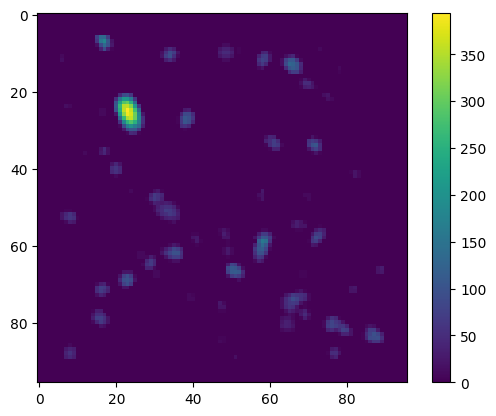

In [178]:
plt.imshow(out1.sum(axis=(2,3)))
plt.colorbar()
plt.show()

In [179]:
#find remaining hotspots 
blobs, significance = demeter.find_blobs(out1, threshold=9)

In [180]:
print(blobs)
print(significance)

[[25.585974025974025, 23.313766233766234, 26.84987012987013, 24.170909090909092, 9.296958630725136, 6.6035721901943605, 5.965521293363151, 9.179886691020537]]
[9.03312873840332]


In [181]:
#find clusters in original dataset 
clusters_demeter = demeter.find_clusters(data_dwarf, x_dwarf, y_dwarf, gnomonic_width, pmfield_size, grid_size, blobs)

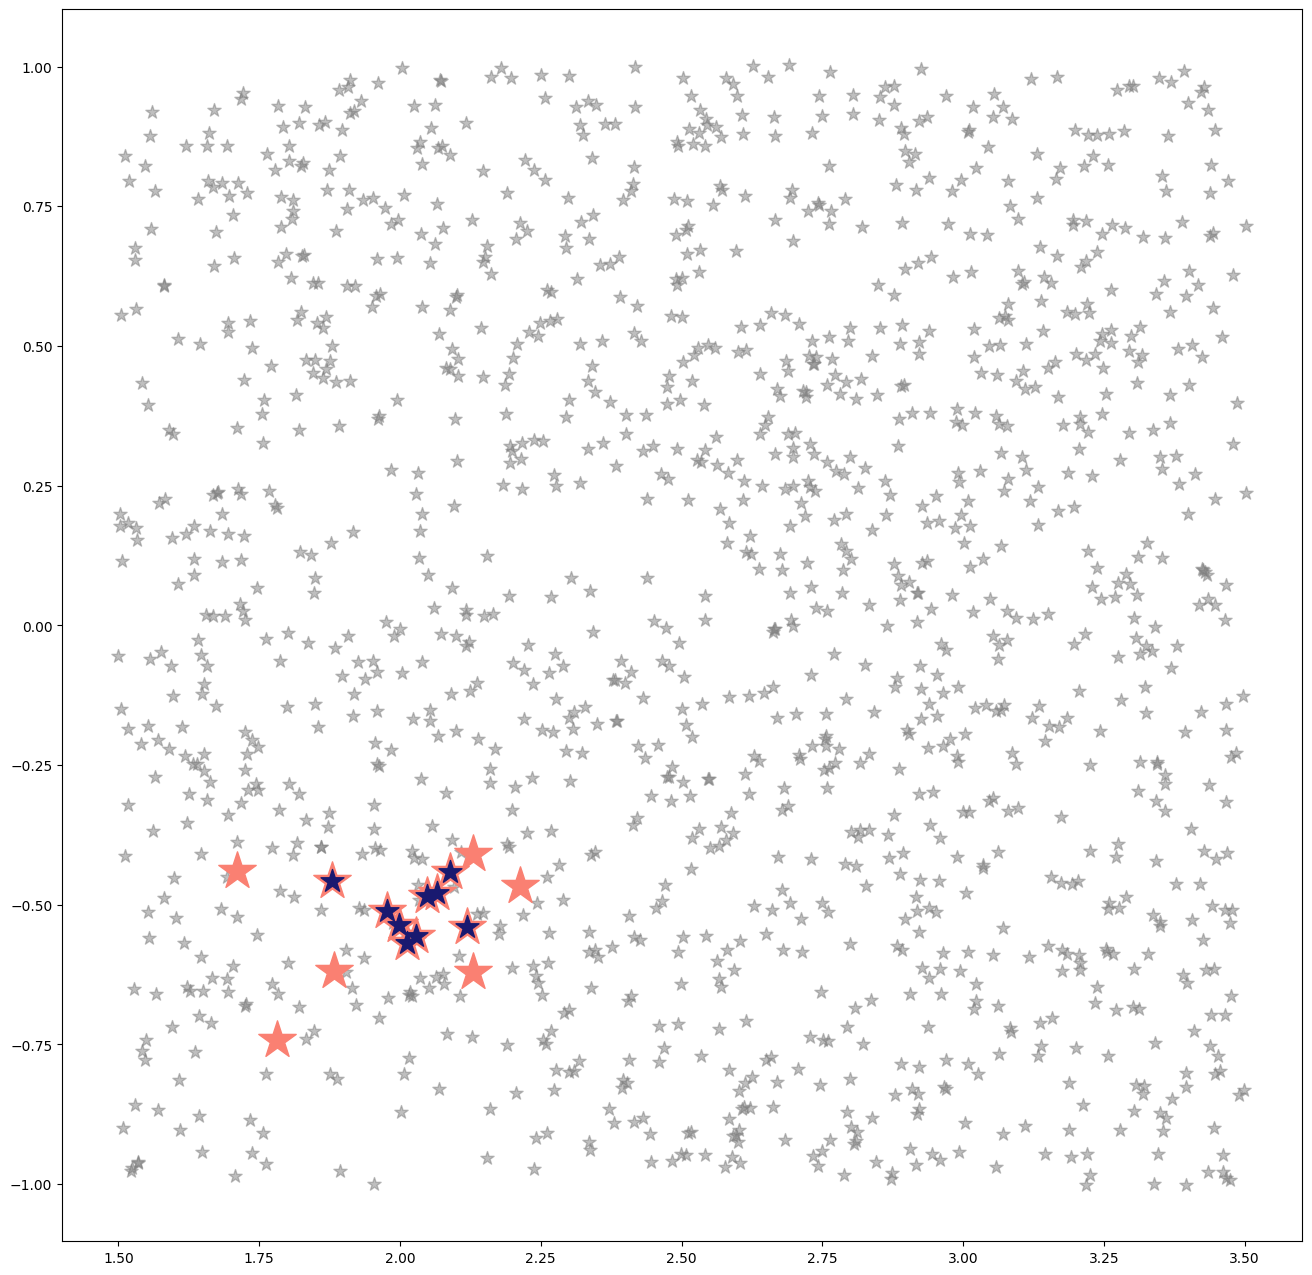

all injected stars recovered successfully!


In [182]:
fig, ax = plt.subplots(figsize=(16,16))

#plot background stars 
plt.scatter(data['ra'],data['dec'], alpha=0.5, color='grey', s=100, marker='*')

#plot injected stars 
plt.scatter(dwarf['ra'], dwarf['dec'], alpha=1., color='salmon',s=800, marker='*')

#plot returned stars
for cluster in clusters_demeter:
    if(len(cluster)>=5):
        plt.scatter(cluster['ra'], cluster['dec'], color='midnightblue',s=300, marker='*')

plt.show()

mask = np.isin(cluster['ra'], dwarf['ra'])

if(len(cluster[mask]==len(dwarf))):
    print('all injected stars recovered successfully!')

In [183]:
#calculate cluster poission significance 

#first filter field stars by cluster proper motio n
maxpmra = np.max(cluster['pmra'])
minpmra = np.min(cluster['pmra'])
maxpmdec = np.max(cluster['pmdec'])
minpmdec = np.min(cluster['pmdec'])

mask1 = data_dwarf['pmra'] <= maxpmra
mask2 = data_dwarf['pmra'] >= minpmra
mask3 = data_dwarf['pmdec'] <= maxpmdec
mask4 = data_dwarf['pmdec'] >= minpmdec
mask = mask1 & mask2 & mask3 & mask4
    
#calculate poisson rate for remaining stars 
poisson_rate = len(x_dwarf[mask])
x_clust, y_clust = demeter.to_gnomonic(cluster['ra'], cluster['dec'], median_ra, median_dec) 
area = (np.pi/4*(np.max(x_clust) - np.min(x_clust))*(np.max(y_clust) - np.min(y_clust)))/(4*gnomonic_width**2)

#calculate poisson significance 
poisson_int = (np.mean(scipy.stats.poisson(poisson_rate*area).rvs(10000)))
significance_poisson = ((len(cluster)-poisson_int)/np.sqrt(poisson_int))

print('wavelet significance: ' + str(np.round(significance[0], 2)))
print('poisson significance: ' + str(np.round(significance_poisson)))


wavelet significance: 9.03
poisson significance: 25.0


# EagleEye

In [184]:
K_M

20

In [185]:
result_dict_list_pos = []
EE_book_list_pos = []
clusters_list_pos = []

result_dict_list_vel = []
EE_book_list_vel = []
clusters_list_vel = []

result_dict_list = []
EE_book_list = []
clusters_list = []
for ref in references:
    K_M = 20#int(0.15 * len(full_field))
    p = len(full_field)/(len(full_field)+len(ref))
    p_ext = 1e-5

    aux_full_field = np.copy(full_field)
    aux_ref = np.copy(ref)
    aux_full_field = (aux_full_field - np.min(full_field, axis = 0)) / (np.max(full_field, axis = 0) - np.min(full_field, axis = 0)) 
    aux_ref = (aux_ref - np.min(full_field, axis = 0)) / (np.max(full_field, axis = 0) - np.min(full_field, axis = 0)) 
    
    stats_null = compute_the_null(p=p, K_M=K_M)
    result_dictionary, stats_null = EagleEye.Soar(aux_ref[:,:2], aux_full_field[:,:2], K_M=K_M, p_ext=p_ext, n_jobs=100, 
                                          stats_null=stats_null, result_dict_in={})
    clusters = partitioning_function(aux_ref[:,:2], aux_full_field[:,:2], result_dictionary, p_ext=p_ext, Z=2.65 )
    EE_book = EagleEye.Repechage(aux_ref[:,:2], aux_full_field[:,:2], result_dictionary, clusters, p_ext=p_ext)

    result_dict_list_pos.append(result_dictionary)
    EE_book_list_pos.append(EE_book)
    clusters_list_pos.append(clusters)

    result_dictionary, stats_null = EagleEye.Soar(aux_ref[:,2:], aux_full_field[:,2:], K_M=K_M, p_ext=p_ext, n_jobs=100, 
                                          stats_null=stats_null, result_dict_in={})
    clusters = partitioning_function(aux_ref[:,2:], aux_full_field[:,2:], result_dictionary, p_ext=p_ext, Z=2.65 )
    EE_book = EagleEye.Repechage(aux_ref[:,2:], aux_full_field[:,2:], result_dictionary, clusters, p_ext=p_ext)

    result_dict_list_vel.append(result_dictionary)
    EE_book_list_vel.append(EE_book)
    clusters_list_vel.append(clusters)

    result_dictionary, stats_null = EagleEye.Soar(aux_ref, aux_full_field, K_M=K_M, p_ext=p_ext, n_jobs=100, 
                                          stats_null=stats_null, result_dict_in={})
    clusters = partitioning_function(aux_ref, aux_full_field, result_dictionary, p_ext=p_ext, Z=2.65 )
    EE_book = EagleEye.Repechage(aux_ref, aux_full_field, result_dictionary, clusters, p_ext=p_ext)

    result_dict_list.append(result_dictionary)
    EE_book_list.append(EE_book)
    clusters_list.append(clusters)

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

In [186]:
# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq = np.zeros(len(full_field))
for i in range(len(full_field)):
    try:
        freq[i] = index_count[i]
    except:
        pass

# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list_pos[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq_pos = np.zeros(len(full_field))
for i in range(len(full_field)):
    try:
        freq_pos[i] = index_count[i]
    except:
        pass

# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list_vel[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq_vel = np.zeros(len(full_field))
for i in range(len(full_field)):
    try:
        freq_vel[i] = index_count[i]
    except:
        pass

In [187]:
result_dict_list_pos[0]

{'Upsilon_star_plus': {1e-05: 11.034162219324463},
 'Upsilon_star_minus': {1e-05: 11.146752550454094},
 'stats_null': {0.501759324419423: array([1.66, 2.39, 0.68, ..., 0.68, 0.51, 0.15]),
  0.49824067558057705: array([1.78, 0.4 , 0.1 , ..., 1.69, 1.78, 1.08])},
 'K_M': 20,
 'p_ext': 1e-05,
 'Knn_model': NearestNeighbors(metric='euclidean', n_jobs=100, n_neighbors=200),
 'Upsilon_i_Y': array([3.39, 2.39, 1.  , ..., 4.6 , 0.69, 4.13]),
 'Y^+': array([], dtype=int64),
 'Upsilon_i_Y_inj': array([5.  , 1.46, 0.88, ..., 2.39, 0.69, 0.2 ]),
 'Y_underscore^+': array([257]),
 'Y_IDE': {},
 'Y_Pruned': {},
 'Upsilon_i_X': array([0.21, 2.23, 1.95, ..., 0.4 , 1.78, 3.1 ]),
 'X^+': array([], dtype=int64),
 'Upsilon_i_X_inj': array([0.21, 0.7 , 1.82, ..., 0.22, 2.43, 0.22]),
 'X_underscore^+': array([], dtype=int64),
 'X_IDE': {},
 'X_Pruned': {},
 'Condition_3': True}

In [188]:
EE_book_list_pos[0]

{'Y_OVER_clusters': {0: {'Putative': [],
   'Pruned': [],
   'Repechaged': [],
   'Background': []}},
 'X_OVER_clusters': {0: {'Putative': [],
   'Pruned': [],
   'Repechaged': [],
   'Background': []}}}

In [189]:
EE_book_list[8]['Y_OVER_clusters'].keys()

dict_keys([0])

In [190]:
len(dwarf)

15

In [225]:
aux_ind = []
cluster_array = np.asarray(cluster)
data_dwarf_array = np.asarray(data_dwarf)
for i in range(len(cluster_array)):
    aux_ind.append(np.where( (cluster_array[i,2] == data_dwarf_array[:,2]) &
             (cluster_array[i,3] == data_dwarf_array[:,3]) &
             (cluster_array[i,4] == data_dwarf_array[:,4]) &
             (cluster_array[i,5] == data_dwarf_array[:,5]))[0][0])

aux_ind = np.asarray(aux_ind)

Th


Text(0.5, 0, '$\\Upsilon_{th}$')

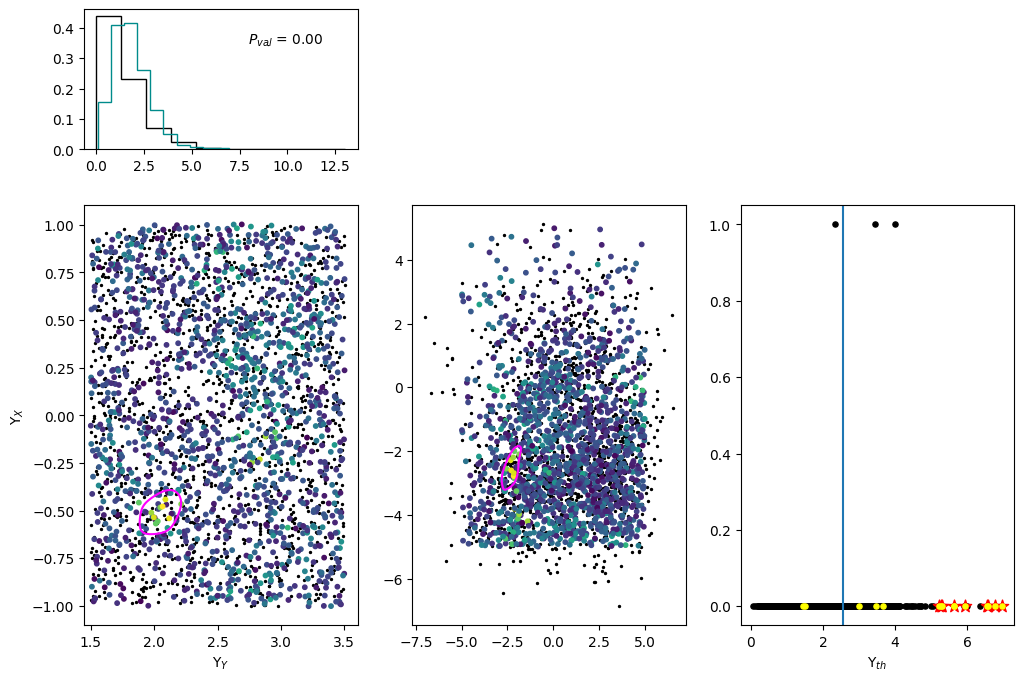

In [228]:
nups = 100
iref = 1
upsilon = result_dict_list[iref]['Upsilon_i_Y']
upsilon_x = result_dict_list[iref]['Upsilon_i_X']


upsilon_list = []
for i in range(len(result_dict_list)-1):
    upsilon = result_dict_list[i]['Upsilon_i_Y']
    upsilon_list.append(upsilon)
upsilon = np.mean(np.asarray(upsilon_list),axis = 0)

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[1,1,1], 'height_ratios':[1,3]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (12,8))

try:
    overdensity_ind = np.asarray(EE_book_list[iref]['Y_OVER_clusters'][0]['Repechaged'])
    if len(overdensity_ind) == 0:
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
        ax[1,2].axvline(x = np.quantile(upsilon, 0.8))
        print('Th')
    else:
        print('Rep')
except:        
    overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
    #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
    ax[1,2].axvline(x = np.quantile(upsilon, 0.8))
    print('Th')
    
bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)

TP = len(np.where(overdensity_ind >= (len(full_field) - len(dwarf)))[0]) # True positives
FP = len(np.where(overdensity_ind < (len(full_field) - len(dwarf)))[0]) # False positives
TN = len(np.where(bkg_ind < (len(full_field) - len(dwarf)))[0]) # True negative
FN = len(np.where(bkg_ind >= (len(full_field) - len(dwarf)))[0]) # False negative

#for jref in range(len(references)):
#    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
#    ax[1,2].plot(up_range, (1-aux_FNR[igal*8 + jref,:]), color = 'blue', alpha = 0.4)
#    ax[1,2].plot(up_range, aux_FPR[igal*8 + jref,:], color = 'orange', alpha = 0.4)
#    ax[1,2].plot(up_range, aux_pur[igal*8 + jref,:], color = 'green', alpha = 0.4)

up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)

statistic, p_value = ks_2samp(upsilon, np.random.choice(result_dict_list[iref]['stats_null'][list(result_dict_list[iref]['stats_null'].keys())[0]], size = len(upsilon)))
ax[0,0].hist(result_dict_list[iref]['stats_null'][list(result_dict_list[iref]['stats_null'].keys())[0]], 
             histtype = 'step', density = True, color = 'black')
ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan')
ax[0,0].text(0.6,0.76,'$P_{val}̣$ = ' + '{:.2f}'.format(p_value), transform = ax[0,0].transAxes)

ax[0,1].set_axis_off()

#ax[1,0].scatter(full_field[-len(dwarf):,0], full_field[-len(dwarf):,1], color = 'orange', s = 55, marker = '*', zorder = 0)
ax[1,0].scatter(references[iref][:,0], references[iref][:,1], color = 'black', s = 2, zorder = 0)
ax[1,0].scatter(full_field[:,0], full_field[:,1], c = upsilon, s = 10)
sns.kdeplot(x=full_field[-len(dwarf):,0], y=full_field[-len(dwarf):,1], color = 'magenta', fill=False, ax = ax[1,0], levels = [0.5])
#for cluster in clusters_demeter:
#    ax[1,0].scatter(cluster['ra'], cluster['dec'], color='magenta',s=300, marker='*',zorder=0)


#%ax[1,0].scatter(full_field[:,0], full_field[:,1], label = f'#Bkg + Dwarf ({len(upsilon)})', color = 'black', s = 10)
#%ax[1,0].scatter(full_field[:,0][-len(dwarf):], full_field[:,1][-len(dwarf):], label = f'#FN {FN}', color = 'coral')
#%ax[1,0].scatter(full_field[:,0][overdensity_ind], full_field[:,1][overdensity_ind], color = 'darkcyan', #marker = 'o',s=52, facecolors='none', 
#%                label = f"#TP {len(np.where(overdensity_ind >= (len(full_field) - len(dwarf)))[0])}")
#%ax[1,0].scatter(full_field[:,0][overdensity_ind[np.where(overdensity_ind < (len(full_field) - len(dwarf)))[0]]],
#%                full_field[:,1][overdensity_ind[np.where(overdensity_ind < (len(full_field) - len(dwarf)))[0]]], color = 'red', 
#%                label = f"#FP {len(np.where(overdensity_ind < (len(full_field) - len(dwarf)))[0])}")
#%ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (1.99,1.5), frameon = False)

#ax[1,1].scatter(full_field[-len(dwarf):,2], full_field[-len(dwarf):,3], color = 'orange', s = 55, marker = '*')
ax[1,1].scatter(full_field[:,2], full_field[:,3], c = upsilon, s = 10)
ax[1,1].scatter(references[iref][:,2], references[iref][:,3], color = 'black', s = 2, zorder = 0)
#ax[1,1].hist(full_field[:,1], histtype = 'step', density = True, color = 'darkcyan', orientation='horizontal')
#ax[1,1].hist(full_field[:,1][-len(dwarf):], histtype = 'step', density = True, color = 'red', orientation='horizontal')
sns.kdeplot(x=full_field[-len(dwarf):,2], y=full_field[-len(dwarf):,3], color = 'magenta', fill=False, ax = ax[1,1], levels = [0.5])

aux_freq = freq #+ freq_pos #+ freq_vel
ax[1,2].scatter(upsilon, aux_freq, c = 'black', s = 55, marker = '.',zorder=0)
ax[1,2].scatter(upsilon[-len(dwarf):], aux_freq[-len(dwarf):], color = 'yellow', s = 55, marker = '.', zorder = 2)
ax[1,2].scatter(upsilon[aux_ind], aux_freq[aux_ind], color = 'red', s = 85, marker = '*', zorder = 1)

ax[1,0].set_xlabel('$\\Upsilon_{Y}$')
ax[1,0].set_ylabel('$\\Upsilon_{X}$')

ax[0,2].set_axis_off()

ax[1,2].set_xlabel('$\\Upsilon_{th}$')

#colors = ['blue', 'orange', 'green']
#labels = ['TPR', 'FPR', 'Pur']

#custom_legend = [Line2D([0], [0], color=color, lw=2, label=label) 
#                    for color, label in zip(colors, labels)]
#ax[1,2].legend(handles = custom_legend, loc = 'upper right', bbox_to_anchor = (0.80,1.20), frameon = False, ncol = 2)

#ax[1,0].set_xlim(-0.008, -0.012)
#ax[1,0].set_ylim(-0.008, -0.012)

#### Deprecated

In [650]:
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [30]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')



In [31]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 1000            # Number of Bernoulli sequences
K_M = 40                        # Length of each sequence
NUM_CORES = 1
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold

# Generate a Bernoulli matrix with sequences of 0s and 1s
bernoulli_sequences = np.random.binomial(n=1, p=0.5, size=(num_sequences, K_M))

# Compute Upsilon values and optimal k-star values for Bernoulli sequences
p_value_data, upsilon_values_bernoulli, optimal_kstar_bernoulli = compute_upsilon_values(bernoulli_sequences, neighbor_range=NEIGHBOR_RANGE, num_cores=NUM_CORES)

# Calculate the critical Upsilon threshold at the specified quantile
critical_upsilon_threshold = np.quantile(upsilon_values_bernoulli, critical_quantile)


Processing partition 1/1 completed.


In [32]:
critical_upsilon_threshold

10.867257399487167

In [33]:
data_dwarf_ar = np.array(data_dwarf[['ra','dec','pmra','pmdec']])
#%data_dwarf_ar = full_field

In [34]:
data_ref_ar = np.array(data[['ra','dec','pmra','pmdec']])
#%data_ref_ar = ref_field[:,:2] 

In [35]:
rand_ra, rand_dec = demeter.from_gnomonic(rand_x,rand_y,median_ra,median_dec)
data_rand_ar = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]
#%data_rand_ar = random_field[:,:2] 

In [36]:
rand_ra = np.random.choice(data_dwarf['ra'], len(data_dwarf), replace = False)
rand_dec = np.random.choice(data_dwarf['dec'], len(data_dwarf), replace = False)
data_rand_ar = np.c_[rand_ra, rand_dec, data_dwarf['pmra'], data_dwarf['pmdec']]


(-3.5, -1.9)

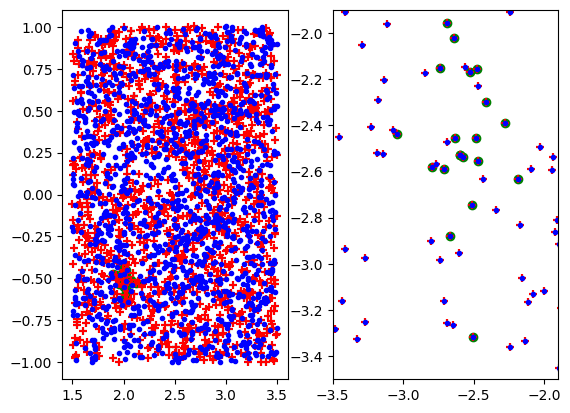

In [37]:
fig,ax = plt.subplots(1,2)

#ax[0].scatter(x_dwarf, y_dwarf, c = 'green')
ax[0].scatter(ra_inj, dec_inj, c = 'green')
ax[0].scatter(data_ref_ar[:,0], data_ref_ar[:,1], c = 'black', marker = '+')
ax[0].scatter(data_dwarf_ar[:,0], data_dwarf_ar[:,1], c = 'red', marker = '+')
ax[0].scatter(data_rand_ar[:,0], data_rand_ar[:,1], c = 'blue', marker = '.')

#%ax[0].set_xlim(-0.012, -0.006)
#%ax[0].set_ylim(-0.012, -0.006)

ax[1].scatter(pmra, pmdec, c = 'green')
ax[1].scatter(data_ref_ar[:,2], data_ref_ar[:,3], c = 'black', marker = '+')
ax[1].scatter(data_dwarf_ar[:,2], data_dwarf_ar[:,3], c = 'red', marker = '+')
ax[1].scatter(data_rand_ar[:,2], data_rand_ar[:,3], c = 'blue', marker = '.')
ax[1].set_xlim(-3.5, -1.9)
ax[1].set_ylim(-3.5, -1.9)

In [38]:
# Generate and process binary sequences with anomalies
binary_sequences_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_dwarf_ar, data_rand_ar, num_neighbors = K_M, num_cores = NUM_CORES
)
anomaly_pval_info, upsilon_values_anomaly, kstar_values_anomaly = compute_upsilon_values(
    binary_sequences_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

Processing partition 1/15
Processing partition 2/15
Processing partition 3/15
Processing partition 4/15
Processing partition 5/15
Processing partition 6/15
Processing partition 7/15
Processing partition 8/15
Processing partition 9/15
Processing partition 10/15
Processing partition 11/15
Processing partition 12/15
Processing partition 13/15
Processing partition 14/15
Processing partition 15/15
Processing partition 1/1 completed.


Text(0.5, 0, '$K_{*}^{dwarf}$')

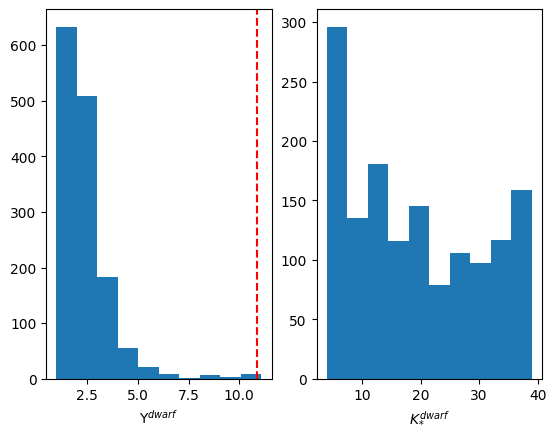

In [39]:
fig,ax = plt.subplots(1,2)

ax[0].hist(upsilon_values_anomaly)
ax[0].axvline(x = critical_upsilon_threshold, c = 'red', ls  = '--')
ax[0].set_xlabel('$\\Upsilon^{dwarf}$')

ax[1].hist(kstar_values_anomaly)
ax[1].set_xlabel('$K_{*}^{dwarf}$')


In [40]:
# Define indices of interest for anomaly data
positive_indices = find_indices_by_threshold(upsilon_values_anomaly, kstar_values_anomaly, 
                                             upsilon_thresh = 6, kstar_thresh = 30)
negative_indices = find_indices_by_threshold(upsilon_values_anomaly, kstar_values_anomaly, 
                                             upsilon_thresh = 3, kstar_thresh = 20, condition = '<')

# Collect Upsilon values for selected indices in anomaly data
upsilon_values_anomaly_selected = extract_upsilon_values(anomaly_pval_info, [positive_indices[0], 359, negative_indices[17]], NEIGHBOR_RANGE)

In [41]:
# Generate and process binary sequences without anomalies
binary_sequences_no_anomaly, _ = From_data_to_binary.create_binary_array_cdist(
    data_ref_ar, data_rand_ar, num_neighbors = K_M, num_cores = NUM_CORES
)
no_anomaly_pval_info, upsilon_values_no_anomaly, kstar_values_no_anomaly = compute_upsilon_values(
    binary_sequences_no_anomaly, NEIGHBOR_RANGE, NUM_CORES
)

Processing partition 1/15
Processing partition 2/15
Processing partition 3/15
Processing partition 4/15
Processing partition 5/15
Processing partition 6/15
Processing partition 7/15
Processing partition 8/15
Processing partition 9/15
Processing partition 10/15
Processing partition 11/15
Processing partition 12/15
Processing partition 13/15
Processing partition 14/15
Processing partition 15/15
Processing partition 1/1 completed.


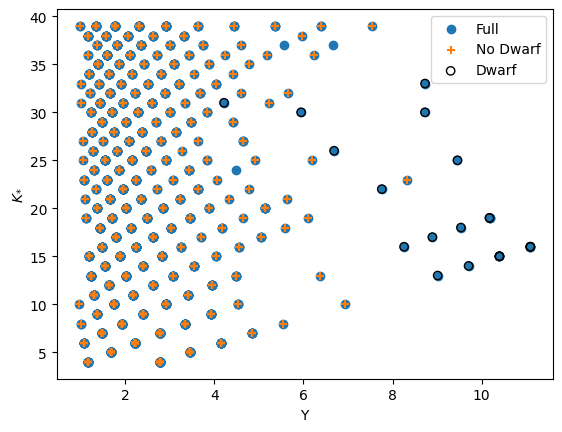

In [42]:
plt.scatter(upsilon_values_anomaly, kstar_values_anomaly, label = 'Full')
plt.scatter(upsilon_values_no_anomaly, kstar_values_no_anomaly, marker = '+', label = 'No Dwarf')
plt.scatter(upsilon_values_anomaly[-20:], kstar_values_anomaly[-20:], facecolors='none', edgecolors='black', marker = 'o', label = 'Dwarf')
plt.ylabel('$K_{*}$')
plt.xlabel('$\\Upsilon$')
plt.legend()

Text(0.5, 0, '$K_{*}$')

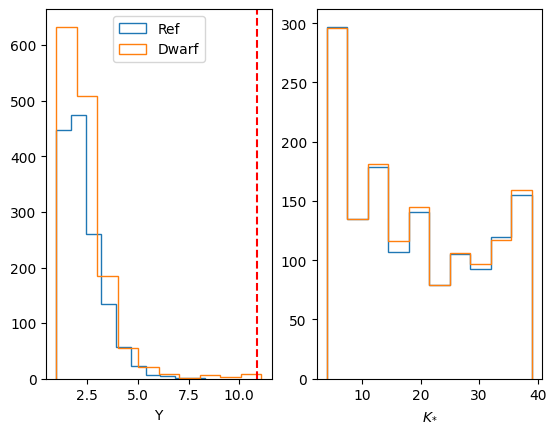

In [43]:
fig,ax = plt.subplots(1,2)

ax[0].hist(upsilon_values_no_anomaly, label = 'Ref', histtype = 'step')
ax[0].hist(upsilon_values_anomaly, label = 'Dwarf', histtype = 'step')
ax[0].axvline(x = critical_upsilon_threshold, c = 'red', ls  = '--')
ax[0].set_xlabel('$\\Upsilon$')
ax[0].legend()

ax[1].hist(kstar_values_no_anomaly, histtype = 'step')
ax[1].hist(kstar_values_anomaly, histtype = 'step')
ax[1].set_xlabel('$K_{*}$')

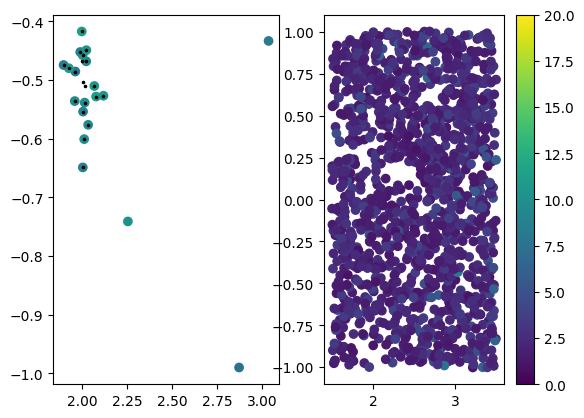

In [44]:
fig,ax = plt.subplots(1,2)
th = 7#critical_upsilon_threshold
ax[0].scatter(data_dwarf_ar[upsilon_values_anomaly > th,0], data_dwarf_ar[upsilon_values_anomaly > th,1], 
              c = upsilon_values_anomaly[upsilon_values_anomaly > th], marker = 'o', vmin = 0, vmax = 20)
#aux = Ellipse((np.mean(ra_inj), np.mean(dec_inj)), np.std(ra_inj), np.std(dec_inj), edgecolor='black',
#              facecolor='none', linewidth=2)
#ax[0].add_patch(aux)
#ax[0].scatter(xx_dwarf, yy_dwarf, facecolors='none', edgecolors='black', marker = 'o')
ax[0].scatter(ra_inj, dec_inj, marker = '.', c = 'black', s = 10)

#ax[0].set_xlim(-0.012, -0.006)
#ax[0].set_ylim(-0.012, -0.006)

im1 = ax[1].scatter(data_ref_ar[:,0], data_ref_ar[:,1], c = upsilon_values_no_anomaly, marker = 'o', vmin = 0, vmax = 20)
plt.colorbar(im1)
#ax[1].set_xlim(-0.012, -0.006)
#ax[1].set_ylim(-0.012, -0.006)

In [45]:
# Define indices of interest for no-anomaly data
no_anomaly_indices_a = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=7, kstar_thresh=50, condition='>')
no_anomaly_indices_b = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=6, kstar_thresh=18, condition='<')
no_anomaly_indices_c = find_indices_by_threshold(upsilon_values_no_anomaly, kstar_values_no_anomaly, upsilon_thresh=2, kstar_thresh=20, condition='<')

# Collect Upsilon values for selected indices in no-anomaly data
upsilon_values_no_anomaly_selected = extract_upsilon_values(no_anomaly_pval_info, [no_anomaly_indices_a[0], no_anomaly_indices_b[17], no_anomaly_indices_c[10]], NEIGHBOR_RANGE)


In [46]:
index_positives_T = np.where((upsilon_values_anomaly > 5) & (np.array(kstar_values_anomaly) < 25))[0][7]
index_positives_F = 359 
index_negatives_q = np.where((upsilon_values_anomaly < 5) & (np.array(kstar_values_anomaly) > 20))[0][ 17]

NLPval_all3 = []
NLPval_all4 = []
NLPval_all5 = []
for j in range(4, K_M):
    NLPval_all3.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_positives_T, 0]))
    NLPval_all4.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_positives_F, 0]))
    NLPval_all5.append(-np.log(anomaly_pval_info.pval_array_dict[j][index_negatives_q, 0]))
    
upsilon_values_anomaly_selected = [ np.array(NLPval_all3), np.array(NLPval_all4), np.array(NLPval_all5) ]


# index_negatives_ = np.where(NLPval_no_anomaly < 15)[0][[1631, 37, 77]]

index_negatives_a = np.where((upsilon_values_no_anomaly > 5) & (upsilon_values_no_anomaly < 11) 
                             & (np.array(kstar_values_no_anomaly) > 10))[0][ 1]
index_negatives_b = np.where((upsilon_values_no_anomaly > 2) & (upsilon_values_no_anomaly < 7) 
                             & (np.array(kstar_values_no_anomaly) < 21) & 
                             (np.array(kstar_values_no_anomaly) > 17) )[0][ 17]
index_negatives_c = np.where((upsilon_values_no_anomaly > 1) & (upsilon_values_no_anomaly < 3) 
                             & (np.array(kstar_values_no_anomaly) > 20))[0][ 10]

NLPval_all0 = []
NLPval_all1 = []
NLPval_all2 = []
for j in range(4, K_M):
    NLPval_all1.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_a, 0]))
    NLPval_all2.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_b, 0]))
    NLPval_all0.append(-np.log(no_anomaly_pval_info.pval_array_dict[j][index_negatives_c, 0]))

upsilon_values_no_anomaly_selected = [ np.array(NLPval_all0), np.array(NLPval_all1), np.array(NLPval_all2) ]

Computation of distances started
Computation of the distances up to 10 NNs started
0.02 seconds for computing distances
ID estimation finished: selecting ID of 3.541746025987547
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
Number of clusters before multimodality test= 1
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 3.719329833984375e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0008294582366943359


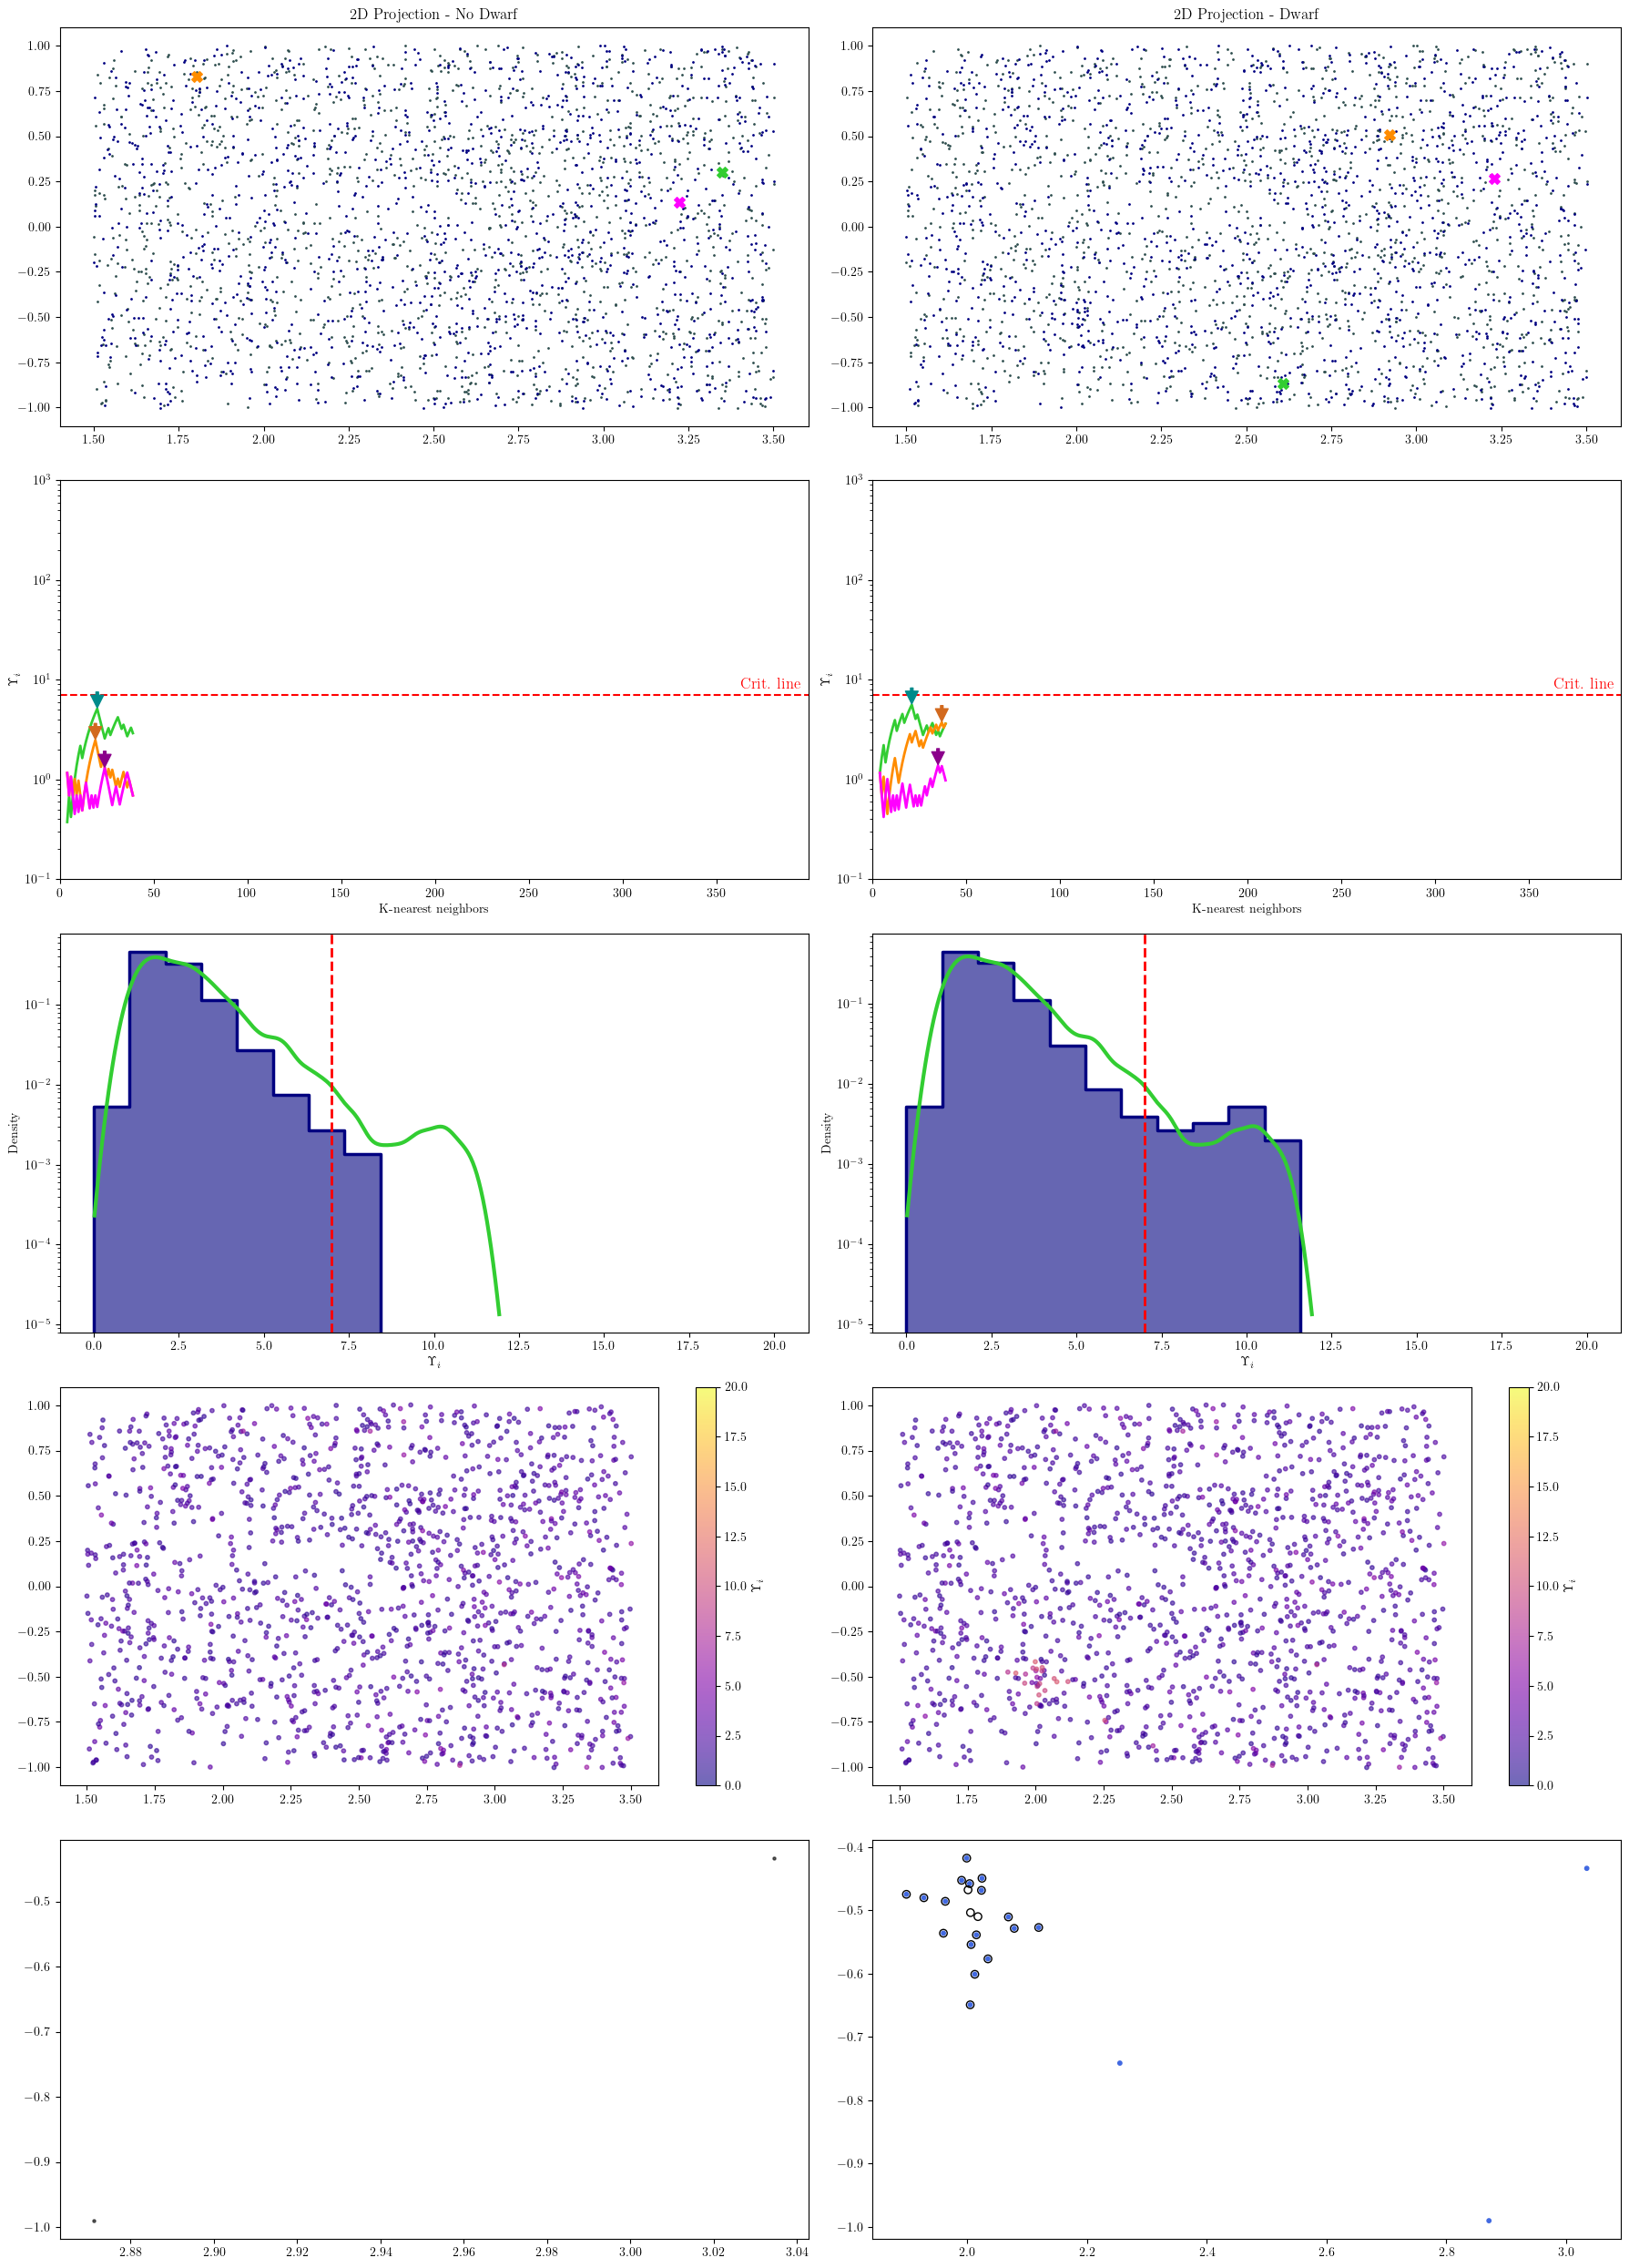

In [47]:
custom_rgb = (234 / 255, 234 / 255, 242 / 255)
axislim = [-4, 5]
crit_val = 7#critical_upsilon_threshold  # Example critical value


plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


# Set up the 5x2 grid for subplots
fig, axs = plt.subplots(5, 2, figsize=(18, 25))

# Scatter plots for no-anomaly and anomaly data in the first row
axs[0, 0].scatter(data_ref_ar[:,0], data_ref_ar[:,1], s=1.0, color='darkslategray', label='Reference')
axs[0, 0].scatter(data_rand_ar[:, 0], data_rand_ar[:, 1], s=1.0, color='navy', label='Data')
axs[0, 0].set_title('2D Projection - No Dwarf')
#axs[0, 0].set_xlim(-0.025,0.025)
#axs[0, 0].set_ylim(-0.025,0.025)

axs[0, 1].scatter(data_rand_ar[:, 0], data_rand_ar[:, 1], s=1.0, color='darkslategray', label='Reference')
axs[0, 1].scatter(data_dwarf_ar[:, 0], data_dwarf_ar[:, 1], s=1.0, color='navy', label='Data')
axs[0, 1].set_title('2D Projection - Dwarf')

# Row 2: Upsilon plots for no anomalies and with anomalies
plot_nlpval(axs[1, 0], upsilon_values_no_anomaly_selected[1], upsilon_values_no_anomaly_selected[2], 
            upsilon_values_no_anomaly_selected[0], label1='TN1', label2='TN2', label3='TN3', crit_v=crit_val)
axs[1, 0].set_ylim([1e-1, 1000])

plot_nlpval(axs[1, 1], upsilon_values_anomaly_selected[0], upsilon_values_anomaly_selected[1], 
            upsilon_values_anomaly_selected[2], label1='TP', label2='FP', label3='TN', crit_v=crit_val)
axs[1, 1].set_ylim([1e-1, 1000])


#%% add the points to the previous row
axs[0, 0].scatter(data_ref_ar[index_negatives_a, 0], data_ref_ar[index_negatives_a, 1], s=70.0, marker='X', c='limegreen', alpha=1, label='TN1')
axs[0, 0].scatter(data_ref_ar[index_negatives_b, 0], data_ref_ar[index_negatives_b, 1], s=70.0, marker='X',c='darkorange', alpha=1, label='TN2')
axs[0, 0].scatter(data_ref_ar[index_negatives_c, 0], data_ref_ar[index_negatives_c, 1], s=70.0, marker='X',c='magenta', alpha=1, label='TN3')
# axs[0, 0].legend()
axs[0, 1].scatter(data_dwarf_ar[index_positives_T, 0], data_dwarf_ar[index_positives_T, 1], s=70.0, marker='X',c='limegreen', alpha=1, label='TP')
axs[0, 1].scatter(data_dwarf_ar[index_positives_F, 0], data_dwarf_ar[index_positives_F, 1], s=70.0, marker='X',c='darkorange', alpha=1, label='FP')
axs[0, 1].scatter(data_dwarf_ar[index_negatives_q, 0], data_dwarf_ar[index_negatives_q, 1], s=70.0, marker='X',c='magenta', alpha=1, label='TN')
# axs[0, 1].legend()

# Row 3: Histograms of Upsilon distributions
sns.histplot(upsilon_values_no_anomaly, bins=np.linspace(0, 20, 20), kde=False, stat='density', label='No Anomaly', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=axs[2, 0])
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[2, 0])
axs[2, 0].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Critical Value')
axs[2, 0].set_yscale('log')
axs[2, 0].set_xlabel(r'$\Upsilon_i$')
#axs[2, 0].set_ylim([1e-4, 1e0])


sns.histplot(np.clip(upsilon_values_anomaly, a_min=None, a_max=40), bins=np.linspace(0, 20, 20), kde=False, stat='density', label='With Anomaly', color='navy', element='step', linewidth=2.5, alpha=0.6, ax=axs[2, 1])
sns.kdeplot(upsilon_values_bernoulli, color='limegreen', linewidth=3, ax=axs[2, 1])
axs[2, 1].axvline(crit_val, color='red', linestyle='--', linewidth=2, label='Critical Value')
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel(r'$\Upsilon_i$')
#axs[2, 1].set_ylim([1e-4, 1e0])

# Row 4: Color-coded scatter plots by Upsilon
sc1 = axs[3, 0].scatter(data_ref_ar[:, 0], data_ref_ar[:, 1], s=10.0, c=upsilon_values_no_anomaly
                        , cmap='plasma', alpha=0.6, vmin=0, vmax=20)
plt.colorbar(sc1, ax=axs[3, 0], label=r'$\Upsilon_i$')
sc2 = axs[3, 1].scatter(data_dwarf_ar[:, 0], data_dwarf_ar[:, 1], s=10.0, c=upsilon_values_anomaly
                        , cmap='plasma', alpha=0.6, vmin=0, vmax=20)
plt.colorbar(sc2, ax=axs[3, 1], label=r'$\Upsilon_i$')

# Row5: Clustering


X = data_dwarf_ar[upsilon_values_anomaly>crit_val,:]

data_aux = Data(X, verbose=True)
data_aux.compute_distances(maxk=10)
data_aux.compute_id_2NN()
data_aux.compute_density_kstarNN()
data_aux.compute_clustering_ADP(Z=2.65, halo=True)

Nclus_m = len(data_aux.cluster_centers)
cmap = plt.get_cmap("cool", Nclus_m)
mix_clustered_ = np.squeeze(X[data_aux.cluster_assignment[:] != -1,:])
mix_clustered_halo = np.squeeze(X[data_aux.cluster_assignment[:] == -1,:])

axs[4, 1].scatter(mix_clustered_halo[:,0],mix_clustered_halo[:,1], s=5.0, c='black', alpha=0.6)

# Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
unique_clusters = sorted(set(data_aux.cluster_assignment[data_aux.cluster_assignment > -1]))

# Create a colormap using only as many colors as the number of unique clusters
cmap = ListedColormap(colorsss[:len(unique_clusters)])

# Create a BoundaryNorm that matches the number of clusters
norm = BoundaryNorm([i for i in range(len(unique_clusters)+1)], cmap.N)

sc = axs[4, 1].scatter(
mix_clustered_[:, 0],               # x-coordinates
mix_clustered_[:, 1],               # y-coordinates
s=10.0,                             # marker size
c=data_aux.cluster_assignment[data_aux.cluster_assignment > -1],  # Use cluster assignments directly
cmap=cmap,                           # Use the ListedColormap
norm=norm,                           # Normalize the colors
alpha=1   )                           # Transparency 
 
#axs[4, 1].set_xlim(axislim)
#axs[4, 1].set_ylim(axislim)


X = data_ref_ar[upsilon_values_no_anomaly>crit_val,:]
if X.shape[0]>10:
    data_aux = Data(X, verbose=True)
    data_aux.compute_distances(maxk= (len(X) - 2))
    data_aux.compute_id_2NN()
    data_aux.compute_density_kstarNN()
    data_aux.compute_clustering_ADP(Z=2.65, halo=True)
    
    Nclus_m = len(data_aux.cluster_centers)
    cmap = plt.get_cmap("cool", Nclus_m)
    mix_clustered_ = np.squeeze(X[data_aux.cluster_assignment[:] != -1,:])
    mix_clustered_halo = np.squeeze(X[data_aux.cluster_assignment[:] == -1,:])
    
    axs[4, 0].scatter(mix_clustered_halo[:,0],mix_clustered_halo[:,1], s=5.0, c='black', alpha=0.6)
    # Find the unique number of clusters (ignoring any invalid cluster assignments like -1)
    unique_clusters = sorted(set(data_aux.cluster_assignment[data_aux.cluster_assignment > -1]))
    
    # Create a colormap using only as many colors as the number of unique clusters
    cmap = ListedColormap(colorsss[:len(unique_clusters)])
    
    # Create a BoundaryNorm that matches the number of clusters
    norm = BoundaryNorm([i for i in range(len(unique_clusters)+1)], cmap.N)
    sc = axs[4, 1].scatter(
    mix_clustered_[:, 0],               # x-coordinates
    mix_clustered_[:, 1],               # y-coordinates
    s=10.0,                             # marker size
    c=data_aux.cluster_assignment[data_aux.cluster_assignment > -1],  # Use cluster assignments directly
    cmap=cmap,                           # Use the ListedColormap
    norm=norm,                           # Normalize the colors
    alpha=1   )    
    #axs[4, 0].set_xlim(axislim)
    #axs[4, 0].set_ylim(axislim)

else:
    axs[4, 0].scatter(X[:,0],X[:,1], s=5.0, c='black', alpha=0.6)
    #axs[4, 0].set_xlim(axislim)
    #axs[4, 0].set_ylim(axislim)
axs[4,1].scatter(ra_inj, dec_inj, facecolors='none', edgecolors='black', marker = 'o')

plt.tight_layout()
plt.show()

# Adding labels to each subplot
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
for ax, label in zip(axs[:,:].flat, labels):
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=21, fontweight='bold', va='top', ha='left')



# Grid gaussian analysis

In [14]:
#center of the sky field in RA and DEC 
median_ra  = 2.5
median_dec = 0

#width of the field in gnomonic coordinates 
gnomonic_width = 0.0175

#width of the proper motion field 
pmfield_size = 5.0 

data = pd.read_csv('demeter/data/gaia_example_data.csv')
data = data.drop(['pmra_error', 'pmdec_error', 'phot_g_mean_mag', 'g_rp','bp_g', 'bp_rp', 'phot_g_mean_flux', 'phot_g_mean_flux_error',
                  'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                  'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error'], axis=1)

data, x_ref, y_ref = demeter.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)

In [15]:
data.shape

(1411, 8)

In [16]:
from itertools import product
#ndwarf = np.hstack((np.array([7,10,11,12,13,14,15]),np.geomspace(20,100,5)))
#sigma_ang = [0.01,0.1,0.5] #[1e-4,1e-3,1e-2]#np.logspace(-4, -2,5)
#sigma_vel = [0.1,0.25,0.35] #np.logspace(-4, -2,5)

#combinaciones = list(product(ndwarf, sigma_ang, sigma_vel))


In [17]:
np.random.seed(91218)
ndwarf = np.random.uniform(7,100,300)
sigma_ang = 10**(np.random.uniform(-4,-0.3,300))
sigma_vel = 10**(np.random.uniform(-2,-1,300))

combinaciones = list(zip(ndwarf, sigma_ang, sigma_vel))

In [14]:
#np.random.seed(91219)

#ndwarf = np.hstack((ndwarf, np.random.uniform(7,100,150)))
#sigma_ang = np.hstack((sigma_ang, 10**(np.random.uniform(-4,-0.3,150))))
#sigma_vel = np.hstack((sigma_vel, 10**(np.random.uniform(-2,-1,150))))

#combinaciones = list(zip(ndwarf, sigma_ang, sigma_vel))

In [18]:
np.random.seed(91218)

blobs_list = []
significance_list = []
clusters_demeter_list = []

EE_results_pos = []
EE_books_pos = []
EE_clusters_pos = []

EE_results_vel = []
EE_books_vel = []
EE_clusters_vel = []

EE_results = []
EE_books = []
EE_clusters = []

dwarf_list = []
dwarf_list_gno = []

references_list = []

for icomb, comb in tqdm(enumerate(combinaciones[:2])):
    print('Generating data with {} stars, {:.2f} angular sigma and {:.2f} vel sigma...'.format(comb[0],comb[1],comb[2]))
    
    #generate mock data -------------------------------
    pmra = normal(loc = -pmfield_size/2, scale = comb[2], size = int(comb[0]))
    pmdec = normal(loc = -pmfield_size/2, scale = comb[2], size = int(comb[0]))
    xx_dwarf = normal(loc = -gnomonic_width/2, scale = comb[1], size = int(comb[0]))
    yy_dwarf = normal(loc = -gnomonic_width/2, scale = comb[1], size = int(comb[0]))
    ra_inj, dec_inj = demeter.from_gnomonic(xx_dwarf ,yy_dwarf ,median_ra,median_dec)
    #ra_inj  = normal(loc = -gnomonic_width/2, scale = comb[1], size = int(comb[0]))
    #dec_inj = normal(loc = -gnomonic_width/2, scale = comb[1], size = int(comb[0]))
    #xx_dwarf, yy_dwarf = demeter.to_gnomonic(ra_inj ,dec_inj ,median_ra,median_dec)

    #inject stars into Gaia data and re-apply masking --------------------------
    dwarf = pd.DataFrame(columns=data.keys())
    for k in (data.keys()):
        dwarf[k] = np.ones(len(xx_dwarf))
    dwarf['pmra']  = pmra
    dwarf['pmdec'] = pmdec
    dwarf['ra']    = ra_inj
    dwarf['dec']   = dec_inj
    
    data_dwarf = pd.concat([data, dwarf], axis = 0)
    
    data_dwarf, x_dwarf, y_dwarf = demeter.mask_data(data_dwarf, median_ra, median_dec, gnomonic_width, pmfield_size)

    # Create a random field from the bkg and added as more bkg
    rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(data, x_ref, y_ref, gnomonic_width, pmfield_size)
    rand_ra, rand_dec = demeter.from_gnomonic(rand_x ,rand_y ,median_ra,median_dec)
    random_field = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]
    random_field_gno = np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]
    
    full_field = np.c_[data_dwarf['ra'], data_dwarf['dec'], data_dwarf['pmra'], data_dwarf['pmdec']]
    full_field_gno = np.c_[x_dwarf, y_dwarf, data_dwarf['pmra'], data_dwarf['pmdec']]

    full_field = np.vstack((random_field, full_field))
    full_field_gno = np.vstack((random_field_gno, full_field_gno))

    dwarf_list.append(full_field)
    dwarf_list_gno.append(full_field_gno)
    
    # Generate references ----------------------------------
    references = []
    for i in range(4):
        rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(data_dwarf, x_ref, y_ref, gnomonic_width, pmfield_size)
        rand_ra, rand_dec = demeter.from_gnomonic(rand_x ,rand_y ,median_ra,median_dec)
        random_field = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]
        random_field_gno = np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]

        if len(full_field) > len(data_dwarf):
            rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(data_dwarf, x_ref, y_ref, gnomonic_width, pmfield_size)
            rand_ra, rand_dec = demeter.from_gnomonic(rand_x ,rand_y ,median_ra,median_dec)
            random_field = np.vstack((random_field, np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]))
            random_field_gno = np.vstack((random_field_gno, np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]))
        
        references.append(random_field)

    # Create reference from IDE ----------------------------
    #%bkg_result_dict_list = []
    #%bkg_EE_book_list = []
    #%bkg_clusters_list = []
    #%for i, iref in enumerate(references):
    #%    bkg_field = iref
    #%            
    #%    result_dict_aux = []
    #%    EE_book_aux = []
    #%    clusters_aux = []
    #%    for j, jref in enumerate(references):
    #%        if i != j:
    #%            K_M = int(0.15 * len(bkg_field))
    #%            p = len(bkg_field)/(len(bkg_field)+len(jref))
    #%            p_ext = 1e-5
    #%        
    #%            aux_bkg_field = np.copy(bkg_field)
    #%            aux_ref = np.copy(jref)
    #%            aux_bkg_field = (aux_bkg_field - np.min(bkg_field, axis = 0)) / (np.max(bkg_field, axis = 0) - np.min(bkg_field, axis = 0)) 
    #%            aux_ref = (aux_ref - np.min(bkg_field, axis = 0)) / (np.max(bkg_field, axis = 0) - np.min(bkg_field, axis = 0)) 
    #%            
    #%            stats_null = compute_the_null(p=p, K_M=K_M)
    #%        
    #%            result_dictionary, stats_null = EagleEye.Soar(aux_ref, aux_bkg_field, K_M=K_M, p_ext=p_ext, n_jobs=100, 
    #%                                                  stats_null=stats_null, result_dict_in={})
    #%            clusters = partitioning_function(aux_ref, aux_bkg_field, result_dictionary, p_ext=p_ext, Z=2.65 )
    #%            EE_book = EagleEye.Repechage(aux_ref, aux_bkg_field, result_dictionary, clusters, p_ext=p_ext)
    #%        
    #%            result_dict_aux.append( result_dictionary )
    #%            EE_book_aux.append( EE_book )
    #%            clusters_aux.append( clusters )
            
    #%    bkg_result_dict_list.append( result_dict_aux )
    #%    bkg_EE_book_list.append( EE_book_aux )
    #%    bkg_clusters_list.append( clusters_aux )
    #%    
    #%ee_bkg = []
    #%for i, iref in enumerate(references):
    #%    bkg_field = references[i]
    #%    aux_dict = bkg_result_dict_list[i]
    #%    for j in range(len(aux_dict)):
    #%        aux = aux_dict[j]['stats_null'][list(aux_dict[j]['stats_null'].keys())[0]]
    #%        umin,umax = np.quantile(aux, [0.3,0.7])
    #%        aux_ind = np.where( (aux_dict[j]['Upsilon_i_Y'] < umax) & 
    #%                            (aux_dict[j]['Upsilon_i_Y'] > umin))[0]
    #%        if len(ee_bkg) == 0: 
    #%            ee_bkg = bkg_field[aux_ind]
    #%        else:
    #%            ee_bkg = np.vstack((ee_bkg, bkg_field[aux_ind]))
    #%ee_bkg.shape
    #%ee_bkg = np.unique(ee_bkg, axis = 0)
    #%references.append(ee_bkg)
    
    # Let's run demeter ----------------------------
    print('Running demeter...')
    blobs_aux, significance_aux, clusters_demeter_aux = run_demeter(full_field_gno, random_field_gno)
    print(significance_aux)
    blobs_list.append(blobs_aux)
    significance_list.append(significance_aux)
    clusters_demeter_list.append(clusters_demeter_aux)
    
    # Let's run EE ------------------------------------

    print('Running EE...')
    result_dict_list_pos = []
    EE_book_list_pos = []
    clusters_list_pos = []
    
    result_dict_list_vel = []
    EE_book_list_vel = []
    clusters_list_vel = []
    
    result_dict_list = []
    EE_book_list = []
    clusters_list = []
    K_M = int(0.15 * len(full_field))
    aux_full_field = np.copy(full_field)
    aux_full_field = (aux_full_field - np.min(full_field, axis = 0)) / (np.max(full_field, axis = 0) - np.min(full_field, axis = 0)) 

    references_list.append(references)
    for ref in references:
        p = len(full_field)/(len(full_field)+len(ref))
        p_ext = 1e-5
    
        aux_ref = np.copy(ref)
        aux_ref = (aux_ref - np.min(full_field, axis = 0)) / (np.max(full_field, axis = 0) - np.min(full_field, axis = 0)) 
        
        stats_null = compute_the_null(p=p, K_M=K_M)
        
        #%result_dictionary, stats_null = EagleEye.Soar(aux_ref[:,:2], aux_full_field[:,:2], K_M=K_M, p_ext=p_ext, n_jobs=100, 
        #%                                      stats_null=stats_null, result_dict_in={})
        #%clusters = partitioning_function(aux_ref[:,:2], aux_full_field[:,:2], result_dictionary, p_ext=p_ext, Z=2.65 )
        #%EE_book = EagleEye.Repechage(aux_ref[:,:2], aux_full_field[:,:2], result_dictionary, clusters, p_ext=p_ext)
    
        #%result_dict_list_pos.append(result_dictionary)
        #%EE_book_list_pos.append(EE_book)
        #%clusters_list_pos.append(clusters)
    
        #%result_dictionary, stats_null = EagleEye.Soar(aux_ref[:,2:], aux_full_field[:,2:], K_M=K_M, p_ext=p_ext, n_jobs=100, 
        #%                                      stats_null=stats_null, result_dict_in={})
        #%clusters = partitioning_function(aux_ref[:,2:], aux_full_field[:,2:], result_dictionary, p_ext=p_ext, Z=2.65 )
        #%EE_book = EagleEye.Repechage(aux_ref[:,2:], aux_full_field[:,2:], result_dictionary, clusters, p_ext=p_ext)
    
        #%result_dict_list_vel.append(result_dictionary)
        #%EE_book_list_vel.append(EE_book)
        #%clusters_list_vel.append(clusters)
    
        result_dictionary, stats_null = EagleEye.Soar(aux_ref, aux_full_field, K_M=K_M, p_ext=p_ext, n_jobs=100, 
                                              stats_null=stats_null, result_dict_in={})
        clusters = partitioning_function(aux_ref, aux_full_field, result_dictionary, p_ext=p_ext, Z=2.65 )
        EE_book = EagleEye.Repechage(aux_ref, aux_full_field, result_dictionary, clusters, p_ext=p_ext)
    
        result_dict_list.append(result_dictionary)
        EE_book_list.append(EE_book)
        clusters_list.append(clusters)
        
    #%EE_results_pos.append( result_dict_list_pos )
    #%EE_books_pos.append( EE_book_list_pos )
    #%EE_clusters_pos.append( clusters_list_pos )
    
    #%EE_results_vel.append( result_dict_list_vel )
    #%EE_books_vel.append( EE_book_list_vel )
    #%EE_clusters_vel.append( clusters_list_vel )
    
    EE_results.append( result_dict_list )
    EE_books.append( EE_book_list )
    EE_clusters.append( clusters_list )

0it [00:00, ?it/s]

Generating data with 73.38536917194894 stars, 0.00 angular sigma and 0.03 vel sigma...
Running demeter...
[158.89437866210938]
Running EE...
-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

1it [03:37, 217.69s/it]

Generating data with 78.43605123270915 stars, 0.00 angular sigma and 0.06 vel sigma...
Running demeter...
[16.955577850341797]
Running EE...
-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

2it [07:06, 213.42s/it]


In [93]:
with open("/scratch/mdelosri/dwarf/dwarf_list_2.8k.pkl", "wb") as file:
    pickle.dump(dwarf_list, file)
with open("/scratch/mdelosri/dwarf/references_list_2.8k.pkl", "wb") as file:
    pickle.dump(references_list, file)

In [19]:
len(EE_results)

2

In [92]:
len(full_field)

2829

In [94]:
with open("/scratch/mdelosri/dwarf/blobs_list_2.8k.pkl", "wb") as file:
    pickle.dump(blobs_list, file)
with open("/scratch/mdelosri/dwarf/significance_list_2.8k.pkl", "wb") as file:
    pickle.dump(significance_list, file)
with open("/scratch/mdelosri/dwarf/clusters_demeter_2.8k.pkl", "wb") as file:
    pickle.dump(clusters_demeter_list, file)

#with open("/scratch/mdelosri/dwarf/blobs_list_1.4k.pkl", "rb") as file:
#    blobs_list = pickle.load(file)
#with open("/scratch/mdelosri/dwarf/significance_list_1.4k.pkl", "rb") as file:
#    significance_list = pickle.load(file)
#with open("/scratch/mdelosri/dwarf/clusters_demeter_1.4k.pkl", "rb") as file:
#    clusters_demeter = pickle.load(file)    

In [95]:
with open("/scratch/mdelosri/dwarf/clusters_gaussian_2.8k.pkl", "wb") as file:
    pickle.dump(EE_clusters, file)
with open("/scratch/mdelosri/dwarf/books_gaussian_2.8k.pkl", "wb") as file:
    pickle.dump(EE_books, file)
with open("/scratch/mdelosri/dwarf/results_gaussian_2.8k.pkl", "wb") as file:
    pickle.dump(EE_results, file)
    
#with open("/scratch/mdelosri/dwarf/results_gaussian_1.4k.pkl", 'rb') as f:
#    EE_results = pickle.load(f)
#with open("/scratch/mdelosri/dwarf/books_gaussian_1.4k.pkl", 'rb') as f:
#    EE_books = pickle.load(f)
#with open("/scratch/mdelosri/dwarf/clusters_gaussian_1.4k.pkl", 'rb') as f:
#    EE_clusters = pickle.load(f)

In [25]:
EE_results_2 = EE_results 
EE_books_2 = EE_books 
EE_clusters_2 = EE_clusters 

In [34]:
# Let's run demeter
print('Running demeter...')
blobs_bkg, significance_bkg, clusters_demeter_bkg = run_demeter(bkg_field_gno, random_field_gno)
print(significance_bkg)

# Let's run EE

print('Running EE...')

bkg_result_dict_list = []
bkg_EE_book_list = []
bkg_clusters_list = []
for i, iref in enumerate(references):
    bkg_field = iref
            
    result_dict_aux = []
    EE_book_aux = []
    clusters_aux = []
    for j, jref in enumerate(references):
        if i != j:
            K_M = int(0.15 * len(bkg_field))
            p = len(bkg_field)/(len(bkg_field)+len(jref))
            p_ext = 1e-5
        
            aux_bkg_field = np.copy(bkg_field)
            aux_ref = np.copy(jref)
            aux_bkg_field = (aux_bkg_field - np.min(bkg_field, axis = 0)) / (np.max(bkg_field, axis = 0) - np.min(bkg_field, axis = 0)) 
            aux_ref = (aux_ref - np.min(bkg_field, axis = 0)) / (np.max(bkg_field, axis = 0) - np.min(bkg_field, axis = 0)) 
            
            stats_null = compute_the_null(p=p, K_M=K_M)
        
            result_dictionary, stats_null = EagleEye.Soar(aux_ref, aux_bkg_field, K_M=K_M, p_ext=p_ext, n_jobs=100, 
                                                  stats_null=stats_null, result_dict_in={})
            clusters = partitioning_function(aux_ref, aux_bkg_field, result_dictionary, p_ext=p_ext, Z=2.65 )
            EE_book = EagleEye.Repechage(aux_ref, aux_bkg_field, result_dictionary, clusters, p_ext=p_ext)
        
            result_dict_aux.append( result_dictionary )
            EE_book_aux.append( EE_book )
            clusters_aux.append( clusters )
        
    bkg_result_dict_list.append( result_dict_aux )
    bkg_EE_book_list.append( EE_book_aux )
    bkg_clusters_list.append( clusters_aux )

Running demeter...
[]
Running EE...
-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 87.15 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 87.06 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 87.12 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 87.05 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

'!!! No X-Overdensities found !!!'

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/u/m/mdelosri/dwarf/codes/EagleEye/eagleeye/EagleEye.py:84: RuntimeWarning: divide by zero encountered in log
  neg_log_plus = -np.log(cdf_plus)


-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 87.15 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


'DONE!'

<IPython.core.display.Math object>

/u/m/mdelosri/dwarf/codes/EagleEye/eagleeye/EagleEye.py:84: RuntimeWarning: divide by zero encountered in log
  neg_log_plus = -np.log(cdf_plus)


'DONE!'

<IPython.core.display.Math object>

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 11475, n_neighbors = 12980

In [35]:
ee_bkg = []
for i, iref in enumerate(references):
    bkg_field = references[i]
    aux_dict = bkg_result_dict_list[i]
    for j in range(len(aux_dict)):
        aux = aux_dict[j]['stats_null'][list(aux_dict[j]['stats_null'].keys())[0]]
        umin,umax = np.quantile(aux, [0.3,0.7])
        aux_ind = np.where( (aux_dict[j]['Upsilon_i_Y'] < umax) & 
                            (aux_dict[j]['Upsilon_i_Y'] > umin))[0]
        if len(ee_bkg) == 0: 
            ee_bkg = bkg_field[aux_ind]
        else:
            ee_bkg = np.vstack((ee_bkg, bkg_field[aux_ind]))
ee_bkg.shape
ee_bkg = np.unique(ee_bkg, axis = 0)
references.append(ee_bkg)

IndexError: list index out of range

In [36]:
iref = 0
upsilon_list = []
upsilonNull_list = []
pval_list = []
for i in range(len(bkg_result_dict_list[iref])):
    upsilon = bkg_result_dict_list[iref][i]['Upsilon_i_Y']
    upsilonNull = bkg_result_dict_list[iref][i]['stats_null'][list(bkg_result_dict_list[iref][i]['stats_null'].keys())[0]]
    pval_list.append( ks_2samp(np.random.choice(upsilonNull, size = 10000, replace = False), upsilon)[1] )
    upsilon_list.append(upsilon)
    upsilonNull_list.append(upsilonNull)
upsilon_bkg = np.mean(np.asarray(upsilon_list),axis = 0)
up_th_bkg = np.max(np.asarray(upsilonNull_list))
pval_bkg = np.mean(np.asarray(pval_list))

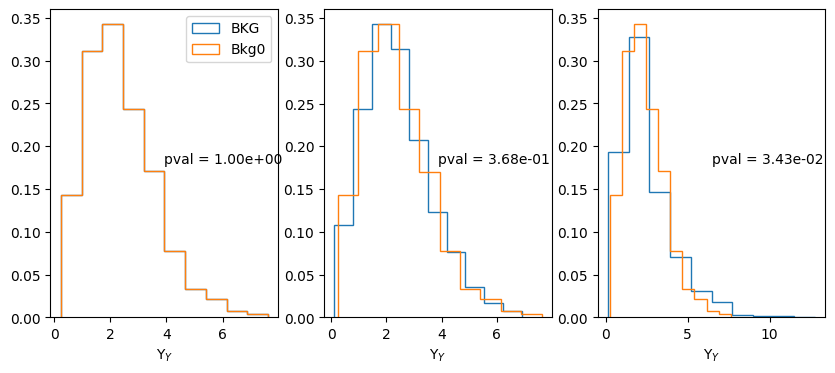

In [336]:
fig,axes = plt.subplots(1,3, figsize = (10,4))
for i, ax in enumerate(axes.flatten()):
    aux = bkg_result_dict_list[i][0]['Upsilon_i_Y']#np.hstack((bkg_result_dict_list[0][i]['Upsilon_i_Y'], bkg_result_dict_list[0][i]['Upsilon_i_X']))
    auxNull = bkg_result_dict_list[0][0]['Upsilon_i_Y']#np.hstack((bkg_result_dict_list[0][0]['Upsilon_i_Y'], bkg_result_dict_list[0][0]['Upsilon_i_X']))
    #auxNull = bkg_result_dict_list[0][i]['stats_null'][list(bkg_result_dict_list[0][i]['stats_null'].keys())[0]]#,
                         #np.hstack((bkg_result_dict_list[0][i]['stats_null'][list(bkg_result_dict_list[0][i]['stats_null'].keys())[1]]))
    ax.hist(aux, histtype = 'step', density = True, label = 'BKG', bins = 10)
    ax.hist(auxNull, histtype = 'step', density = True, label = 'Bkg0', bins = 10)
    pval = ks_2samp(np.random.choice(auxNull, size = 1000, replace = False), aux)[1]
    ax.text(0.5,0.5, 'pval = {:.2e}'.format(pval), transform = ax.transAxes)
    ax.set_xlabel('$\\Upsilon_{Y}$')
axes[0].legend()
#plt.savefig('../graph/BkgVSBkg0_upsY.pdf', bbox_inches = 'tight')

In [119]:
EE_results = EE_results_2
EE_books = EE_books_2
EE_clusters_ = EE_clusters_2

In [60]:
len(dwarf_list)

300

In [ ]:
ires

In [96]:
stats = np.zeros((len(EE_results), 15))

for ires in tqdm(range(len(EE_results))):
    result_dict_list = EE_results[ires]
    EE_book_list = EE_books[ires]
    clusters_list = EE_clusters[ires]
    blobs = blobs_list[ires]
    significance = significance_list[ires]
    clusters_demeter = clusters_demeter_list[ires]
    data_dwarf = dwarf_list[ires]
    full_field = dwarf_list[ires]#np.c_[data_dwarf['ra'], data_dwarf['dec'], data_dwarf['pmra'], data_dwarf['pmdec']]
    ndwarf = int(combinaciones[ires][0])
    dwarf = full_field[-ndwarf:]

    stats[ires,0] = combinaciones[ires][0]
    stats[ires,1] = combinaciones[ires][1]#np.std(dwarf[:,0])# combinaciones[ires][1]
    stats[ires,2] = combinaciones[ires][2]#np.std(dwarf[:,2])# combinaciones[ires][2]
    
    upsilon_list = []
    upsilonNull_list = []
    pval_list = []
    for i in range(len(result_dict_list)):
        upsilon = result_dict_list[i]['Upsilon_i_Y']
        upsilonYX = np.hstack((result_dict_list[i]['Upsilon_i_Y'], result_dict_list[i]['Upsilon_i_X']))
        upsilonX = result_dict_list[i]['Upsilon_i_X']
        upsilonNull = result_dict_list[i]['stats_null'][list(result_dict_list[i]['stats_null'].keys())[0]]
        aux = np.random.choice(upsilonNull, size = 10000, replace = False) #upsilon_bkg # 
        pval_list.append( ks_2samp(aux, upsilon)[1] )
        upsilon_list.append(upsilon)
        upsilonNull_list.append(upsilonNull)
    upsilon = np.mean(np.asarray(upsilon_list),axis = 0)
    up_th = np.max(np.asarray(upsilonNull_list))
    pval = np.mean(np.asarray(pval_list))
    stats[ires,3] = pval
 
    # Let's count how many time a star appear as anomalous
    cluster_indices_list = []
    aux_list = []
    EEpurity = np.zeros(len(references))
    EE_S_SB = np.zeros(len(references))
    for iref in range(len(references)):
        try:
            cls = EE_book_list[iref]['Y_OVER_clusters'] #[0]['Repechaged']
            EEpurity[iref] = S_SB_estimate_Y_overdensities(result_dict_list[iref],EE_book_list[iref])['Purity']['Total']
            EE_S_SB[iref] = S_rootB_estimate(EE_results[ires][iref],EE_books[ires][iref])[0]['Total']
        except:
            cls = []
        if len(cls) > 0:
            for icl, cl in enumerate(cls):
                cluster_indices_list.append( cls[cl]['Repechaged'] )
    
    aux = [elem for lista in cluster_indices_list for elem in lista]
    index_count = Counter(aux)
    
    freq = np.zeros(len(full_field))
    for i in range(len(full_field)):
        try:
            freq[i] = index_count[i]
        except:
            pass

    if len(np.where(freq > 0)[0]) > 0:
        aux_ind = np.where(freq > 0)[0]
        stats[ires,4] = len(np.where(aux_ind >= (len(data_dwarf) - ndwarf))[0]) #TP
        stats[ires,5] = len(np.where(np.delete(np.arange(len(data_dwarf)), aux_ind) > (len(data_dwarf) - ndwarf))[0]) # FN
        stats[ires,6] = len(np.where(np.delete(np.arange(len(data_dwarf)), aux_ind) < (len(data_dwarf) - ndwarf))[0]) # TN
        stats[ires,7] = len(np.where(aux_ind < (len(data_dwarf) - ndwarf))[0]) # FP
    else:
        stats[ires,4] = len(np.where(upsilon[-ndwarf:] >= up_th)[0]) #TP
        stats[ires,5] = len(np.where(upsilon[-ndwarf:] < up_th)[0]) # FN
        stats[ires,6] = len(np.where(upsilon[:-ndwarf] < up_th)[0]) # TN
        stats[ires,7] = len(np.where(upsilon[:-ndwarf] >= up_th)[0]) # FP
    stats[ires,8] = np.mean(EEpurity)
    stats[ires,9] = np.mean(EE_S_SB)
    
    if len(significance) > 0: 
        aux_ind = []
        stats[ires,10] = significance[0]
        cluster_array = np.asarray(clusters_demeter[0])
        data_dwarf_array = np.asarray(data_dwarf)
        for i in range(len(cluster_array)):
            aux_ind.append(np.where( (cluster_array[i,2] == data_dwarf_array[:,1]) &
                     (cluster_array[i,3] == data_dwarf_array[:,0]) &
                     (cluster_array[i,4] == data_dwarf_array[:,2]) &
                     (cluster_array[i,5] == data_dwarf_array[:,3]))[0][0])
        
        aux_ind = np.asarray(aux_ind)
            
        stats[ires,11] = len(np.where(aux_ind >= (len(data_dwarf) - ndwarf))[0]) #TP
        stats[ires,12] = len(np.where(np.delete(np.arange(len(data_dwarf)), aux_ind) > (len(data_dwarf) - ndwarf))[0]) # FN
        stats[ires,13] = len(np.where(np.delete(np.arange(len(data_dwarf)), aux_ind) < (len(data_dwarf) - ndwarf))[0]) # TN
        stats[ires,14] = len(np.where(aux_ind < (len(data_dwarf) - ndwarf))[0]) # FP
    else:
        stats[ires,11] = 0 # TP
        stats[ires,12] = ndwarf # FN
        stats[ires,13] = len(data_dwarf) - ndwarf # TN
        stats[ires,14] = 0

/tmp/ipykernel_872335/3360194596.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  S_B = S_B / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))
/tmp/ipykernel_872335/3360194596.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  S_B[idx] = S_B[idx] / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))

00%|██████████| 300/300 [01:06<00:00,  4.54it/s]

In [98]:
np.save('/scratch/mdelosri/dwarf/stats_2.8k.npy', stats)
stats28 = np.load('/scratch/mdelosri/dwarf/stats_2.8k.npy')
stats14 = np.load('/scratch/mdelosri/dwarf/stats_1.4k.npy')

In [77]:
stats[:,1].max()

0.41438927330189407

/tmp/ipykernel_872335/1282218543.py:14: RuntimeWarning: divide by zero encountered in divide
  s_sb = stats[:,4] / np.sqrt(stats[:,7])
/tmp/ipykernel_872335/1282218543.py:14: RuntimeWarning: invalid value encountered in divide
  s_sb = stats[:,4] / np.sqrt(stats[:,7])
/tmp/ipykernel_872335/1282218543.py:16: RuntimeWarning: invalid value encountered in divide
  pur = stats[:,4] / (stats[:,7] + stats[:,4])


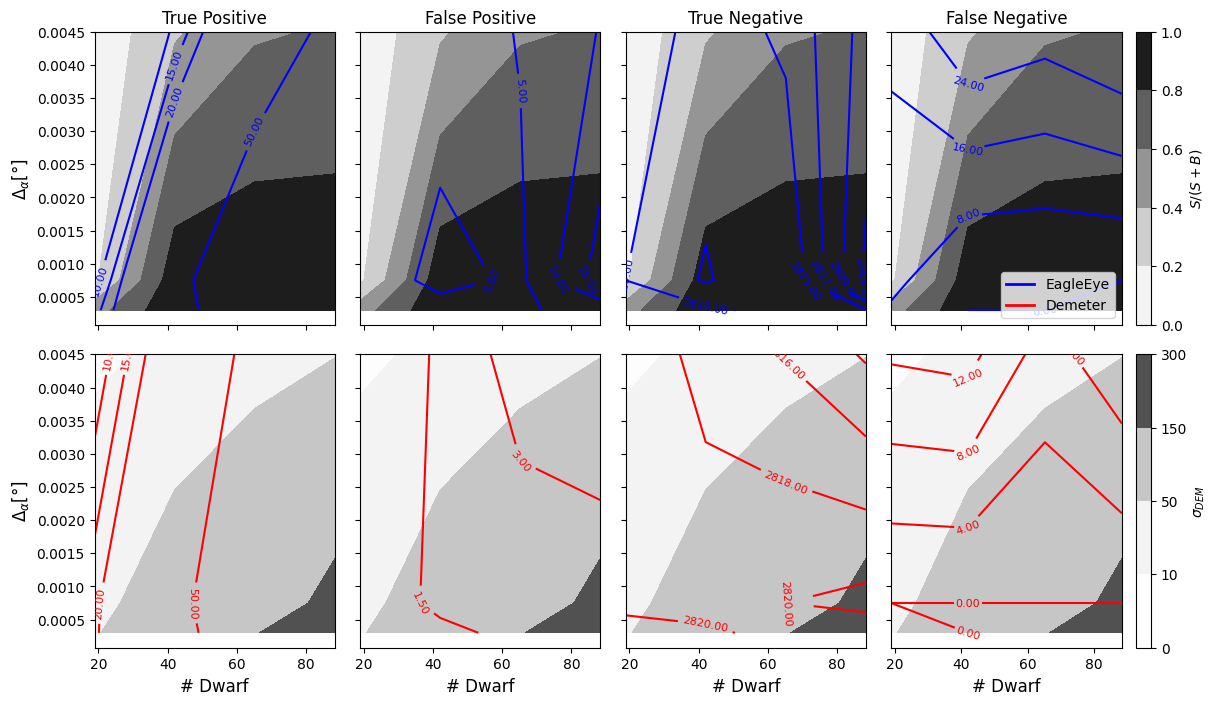

In [114]:
xbins = 4
ybins = [5e-5,1e-4,5e-4,1e-3,8e-3]#[0.5e-4,5e-3,1e-2,1e-1,0.5] #
demeter_sig, x_edge, y_edge, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,10], statistic='mean', bins=[xbins,ybins])
demeter_TP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,11], statistic='mean', bins=[x_edge, y_edge])
demeter_FP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,14], statistic='mean', bins=[x_edge, y_edge])
demeter_TN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,13], statistic='mean', bins=[x_edge, y_edge])
demeter_FN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,12], statistic='mean', bins=[x_edge, y_edge])

EE_sig, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,8], statistic='mean', bins=[x_edge, y_edge])
EE_TP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,4], statistic='mean', bins=[x_edge, y_edge])
EE_FP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,7], statistic='mean', bins=[x_edge, y_edge])
EE_TN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,6], statistic='mean', bins=[x_edge, y_edge])
EE_FN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], stats[:,5], statistic='mean', bins=[x_edge, y_edge])
s_sb = stats[:,4] / np.sqrt(stats[:,7])
s_sb = np.nan_to_num(s_sb,nan=0.0, posinf=110)
pur = stats[:,4] / (stats[:,7] + stats[:,4]) 
pur = np.nan_to_num(pur,nan=0.0, posinf=1.1)

EE_S_SB, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], s_sb, statistic='mean', bins=[x_edge, y_edge])
EE_PUR, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,1], pur, statistic='mean', bins=[x_edge, y_edge])

# Crear coordenadas del centro de los bins para el plot
x_centers = (x_edge[:-1] + x_edge[1:]) / 2
y_centers = (y_edge[:-1] + y_edge[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')

# Graficar con contourf
fig,ax = plt.subplots(2,4, sharey = True, sharex = True, figsize = (14,8), 
                      gridspec_kw={'width_ratios':[1,1,1,1.2], 'hspace':0.1, 'wspace':0.1})

#real_S_SB = ax[0,0].contour(X, Y, EE_PUR, levels=5, colors = 'blue', linestyles = ':')
#ax[0,0].clabel(real_S_SB, inline=True, fontsize=8, fmt="%.2f")
#pred_S_SB = ax[0,0].contour(X, Y, EE_sig, levels=5, colors = 'black', linestyles = ':')
#ax[0,0].clabel(pred_S_SB, inline=True, fontsize=8, fmt="%.2f")

contour_EE = ax[0,0].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
TP1 = ax[0,0].contour(X, Y, EE_TP, levels=[0,10,15,20,50], colors = 'blue')
ax[0,0].clabel(TP1, inline=True, fontsize=8, fmt="%.2f")
ax[0,0].set_ylabel('$\\Delta_{\\alpha} [°]$', fontsize = 12)
#ax[0,0].set_ylabel('$\\Delta_{\\mu} [mas]$', fontsize = 12)
ax[0,0].set_title('True Positive', fontsize = 12)

contour_EE = ax[0,1].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
FP1 = ax[0,1].contour(X, Y, EE_FP, levels=3, colors = 'blue')
ax[0,1].clabel(FP1, inline=True, fontsize=8, fmt="%.2f")
ax[0,1].set_title('False Positive', fontsize = 12)

contour_EE = ax[0,2].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
TN1 = ax[0,2].contour(X, Y, EE_TN, levels=4, colors = 'blue')
ax[0,2].clabel(TN1, inline=True, fontsize=8, fmt="%.2f")
ax[0,2].set_title('True Negative', fontsize = 12)

contour_EE = ax[0,3].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
FN1 = ax[0,3].contour(X, Y, EE_FN, levels=3, colors = 'blue')
ax[0,3].clabel(FN1, inline=True, fontsize=8, fmt="%.2f")
ax[0,3].set_title('False Negative', fontsize = 12)

cbar = plt.colorbar(contour_EE)
cbar.set_label('$S/(S + B)$')

contour = ax[1,0].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
CS=ax[1,0].contour(X, Y, demeter_TP, levels=[0,10,15,20,50], colors = 'red')
ax[1,0].clabel(CS, inline=True, fontsize=8, fmt="%.2f")
ax[1,0].set_xlabel('# Dwarf', fontsize = 12)
ax[1,0].set_ylabel('$\\Delta_{\\alpha} [°]$', fontsize = 12)
#ax[1,0].set_ylabel('$\\Delta_{\\mu} [mas]$', fontsize = 12)

contour = ax[1,1].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
FP=ax[1,1].contour(X, Y, demeter_FP, levels=3, colors = 'red')
ax[1,1].clabel(FP, inline=True, fontsize=8, fmt="%.2f")
ax[1,1].set_xlabel('# Dwarf', fontsize = 12)

contour = ax[1,2].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
TN=ax[1,2].contour(X, Y, demeter_TN, levels=4, colors = 'red')
ax[1,2].clabel(TN, inline=True, fontsize=8, fmt="%.2f")
ax[1,2].set_xlabel('# Dwarf', fontsize = 12)

contour = ax[1,3].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
FN=ax[1,3].contour(X, Y, demeter_FN, levels=3, colors = 'red')
ax[1,3].clabel(FN, inline=True, fontsize=8, fmt="%.2f")
ax[1,3].set_xlabel('# Dwarf', fontsize = 12)

cbar = plt.colorbar(contour)
cbar.set_label('$\\sigma_{DEM}$')

#ax[1,1].set_ylim(0.03, 0.3)

custom_lines = [
    Line2D([0], [0], color='blue', lw=2, linestyle='solid'),
    Line2D([0], [0], color='red', lw=2, linestyle='solid')
]

# Añadir leyenda personalizada
ax[0,3].legend(custom_lines, ['EagleEye', 'Demeter'], loc = 'lower right')

plt.savefig('../graph/GaussianAnalysis_S_SB_2.8k.pdf', bbox_inches = 'tight')

In [105]:
stats[:,2].max()

0.09983682587765821

/tmp/ipykernel_872335/1828399996.py:14: RuntimeWarning: divide by zero encountered in divide
  s_sb = stats[:,4] / np.sqrt(stats[:,7])
/tmp/ipykernel_872335/1828399996.py:14: RuntimeWarning: invalid value encountered in divide
  s_sb = stats[:,4] / np.sqrt(stats[:,7])
/tmp/ipykernel_872335/1828399996.py:16: RuntimeWarning: invalid value encountered in divide
  pur = stats[:,4] / (stats[:,7] + stats[:,4])


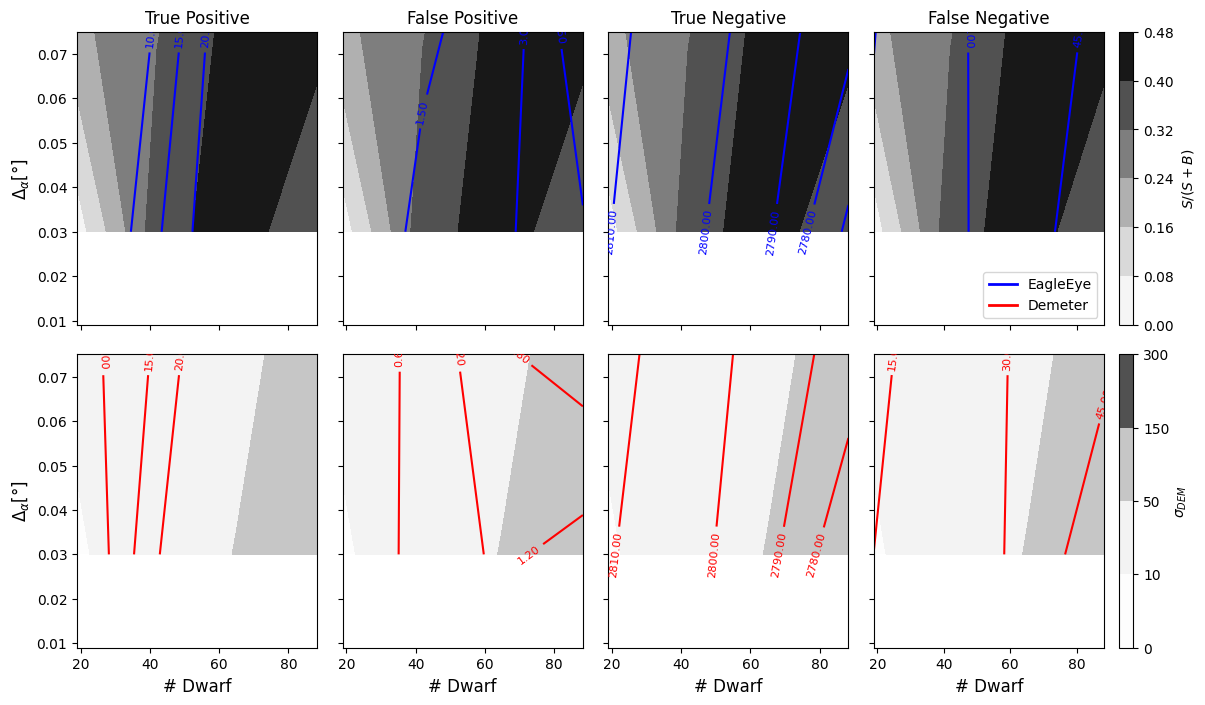

In [118]:
xbins = 4
ybins = [0.008,0.01,0.05,0.1]
demeter_sig, x_edge, y_edge, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,10], statistic='mean', bins=[xbins,ybins])
demeter_TP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,11], statistic='mean', bins=[x_edge, y_edge])
demeter_FP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,14], statistic='mean', bins=[x_edge, y_edge])
demeter_TN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,13], statistic='mean', bins=[x_edge, y_edge])
demeter_FN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,12], statistic='mean', bins=[x_edge, y_edge])

EE_sig, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,8], statistic='mean', bins=[x_edge, y_edge])
EE_TP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,4], statistic='mean', bins=[x_edge, y_edge])
EE_FP, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,7], statistic='mean', bins=[x_edge, y_edge])
EE_TN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,6], statistic='mean', bins=[x_edge, y_edge])
EE_FN, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], stats[:,5], statistic='mean', bins=[x_edge, y_edge])
s_sb = stats[:,4] / np.sqrt(stats[:,7])
s_sb = np.nan_to_num(s_sb,nan=0.0, posinf=110)
pur = stats[:,4] / (stats[:,7] + stats[:,4]) 
pur = np.nan_to_num(pur,nan=0.0, posinf=1.1)

EE_S_SB, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], s_sb, statistic='mean', bins=[x_edge, y_edge])
EE_PUR, _, _, binnumber = binned_statistic_2d(stats[:,0], stats[:,2], pur, statistic='mean', bins=[x_edge, y_edge])

# Crear coordenadas del centro de los bins para el plot
x_centers = (x_edge[:-1] + x_edge[1:]) / 2
y_centers = (y_edge[:-1] + y_edge[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')

# Graficar con contourf
fig,ax = plt.subplots(2,4, sharey = True, sharex = True, figsize = (14,8), 
                      gridspec_kw={'width_ratios':[1,1,1,1.2], 'hspace':0.1, 'wspace':0.1})

#real_S_SB = ax[0,0].contour(X, Y, EE_PUR, levels=5, colors = 'blue', linestyles = ':')
#ax[0,0].clabel(real_S_SB, inline=True, fontsize=8, fmt="%.2f")
#pred_S_SB = ax[0,0].contour(X, Y, EE_sig, levels=5, colors = 'black', linestyles = ':')
#ax[0,0].clabel(pred_S_SB, inline=True, fontsize=8, fmt="%.2f")

contour_EE = ax[0,0].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
TP1 = ax[0,0].contour(X, Y, EE_TP, levels=[0,10,15,20,50], colors = 'blue')
ax[0,0].clabel(TP1, inline=True, fontsize=8, fmt="%.2f")
ax[0,0].set_ylabel('$\\Delta_{\\alpha} [°]$', fontsize = 12)
#ax[0,0].set_ylabel('$\\Delta_{\\mu} [mas]$', fontsize = 12)
ax[0,0].set_title('True Positive', fontsize = 12)

contour_EE = ax[0,1].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
FP1 = ax[0,1].contour(X, Y, EE_FP, levels=3, colors = 'blue')
ax[0,1].clabel(FP1, inline=True, fontsize=8, fmt="%.2f")
ax[0,1].set_title('False Positive', fontsize = 12)

contour_EE = ax[0,2].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
TN1 = ax[0,2].contour(X, Y, EE_TN, levels=4, colors = 'blue')
ax[0,2].clabel(TN1, inline=True, fontsize=8, fmt="%.2f")
ax[0,2].set_title('True Negative', fontsize = 12)

contour_EE = ax[0,3].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
FN1 = ax[0,3].contour(X, Y, EE_FN, levels=3, colors = 'blue')
ax[0,3].clabel(FN1, inline=True, fontsize=8, fmt="%.2f")
ax[0,3].set_title('False Negative', fontsize = 12)

cbar = plt.colorbar(contour_EE)
cbar.set_label('$S/(S + B)$')

contour = ax[1,0].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
CS=ax[1,0].contour(X, Y, demeter_TP, levels=[0,10,15,20,50], colors = 'red')
ax[1,0].clabel(CS, inline=True, fontsize=8, fmt="%.2f")
ax[1,0].set_xlabel('# Dwarf', fontsize = 12)
ax[1,0].set_ylabel('$\\Delta_{\\alpha} [°]$', fontsize = 12)
#ax[1,0].set_ylabel('$\\Delta_{\\mu} [mas]$', fontsize = 12)

contour = ax[1,1].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
FP=ax[1,1].contour(X, Y, demeter_FP, levels=3, colors = 'red')
ax[1,1].clabel(FP, inline=True, fontsize=8, fmt="%.2f")
ax[1,1].set_xlabel('# Dwarf', fontsize = 12)

contour = ax[1,2].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
TN=ax[1,2].contour(X, Y, demeter_TN, levels=4, colors = 'red')
ax[1,2].clabel(TN, inline=True, fontsize=8, fmt="%.2f")
ax[1,2].set_xlabel('# Dwarf', fontsize = 12)

contour = ax[1,3].contourf(X, Y, demeter_sig, levels=[0,10,50,150,300], cmap='Greys')
FN=ax[1,3].contour(X, Y, demeter_FN, levels=3, colors = 'red')
ax[1,3].clabel(FN, inline=True, fontsize=8, fmt="%.2f")
ax[1,3].set_xlabel('# Dwarf', fontsize = 12)

cbar = plt.colorbar(contour)
cbar.set_label('$\\sigma_{DEM}$')

#ax[1,1].set_ylim(0.03, 0.3)

custom_lines = [
    Line2D([0], [0], color='blue', lw=2, linestyle='solid'),
    Line2D([0], [0], color='red', lw=2, linestyle='solid')
]

# Añadir leyenda personalizada
ax[0,3].legend(custom_lines, ['EagleEye', 'Demeter'], loc = 'lower right')

#ax[0,0].scatter(stats[:,0],stats[:,2])
#plt.savefig('../graph/GaussianAnalysis_S_SB_2.8k_vels.pdf', bbox_inches = 'tight')

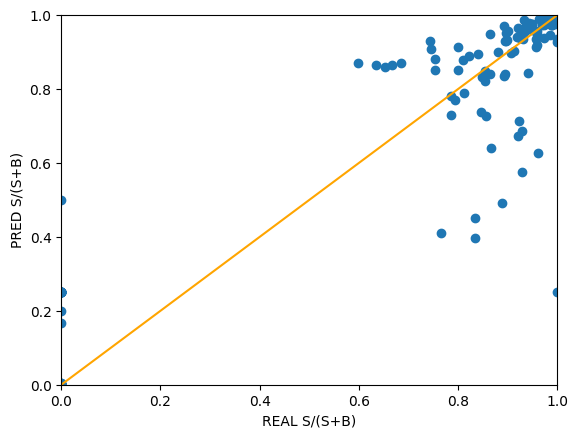

In [101]:
plt.scatter(pur, stats[:,8])
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1], color = 'orange')
plt.xlabel('REAL S/(S+B)')
plt.ylabel('PRED S/(S+B)')
plt.savefig('../graph/real_vs_pred_pur_2.8k.pdf', bbox_inches = 'tight')

Text(0, 0.5, 'PRED $S/\\sqrt{B}$')

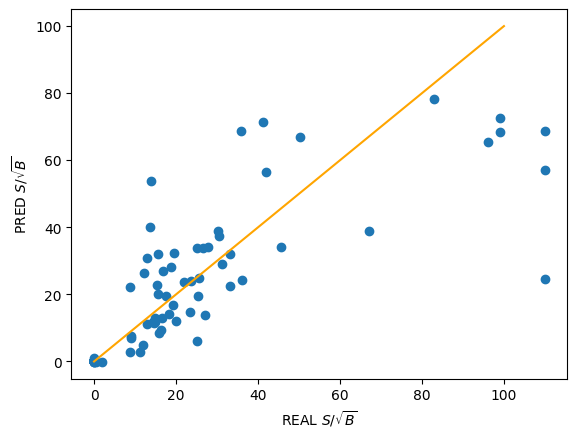

In [102]:
plt.scatter(s_sb, stats[:,9])
#plt.xlim(0,40)
#plt.ylim(0,40)
plt.plot([0,100],[0,100], color = 'orange')
plt.xlabel('REAL $S/\sqrt{B}$')
plt.ylabel('PRED $S/\sqrt{B}$')
#plt.savefig('../graph/real_vs_pred_s_sb_2.8k.pdf', bbox_inches = 'tight')

/tmp/ipykernel_872335/671019812.py:24: RuntimeWarning: divide by zero encountered in divide
  s_sb = stats[:,4] / np.sqrt(stats[:,7])
/tmp/ipykernel_872335/671019812.py:24: RuntimeWarning: invalid value encountered in divide
  s_sb = stats[:,4] / np.sqrt(stats[:,7])
/tmp/ipykernel_872335/671019812.py:26: RuntimeWarning: invalid value encountered in divide
  pur = stats[:,4] / (stats[:,7] + stats[:,4])


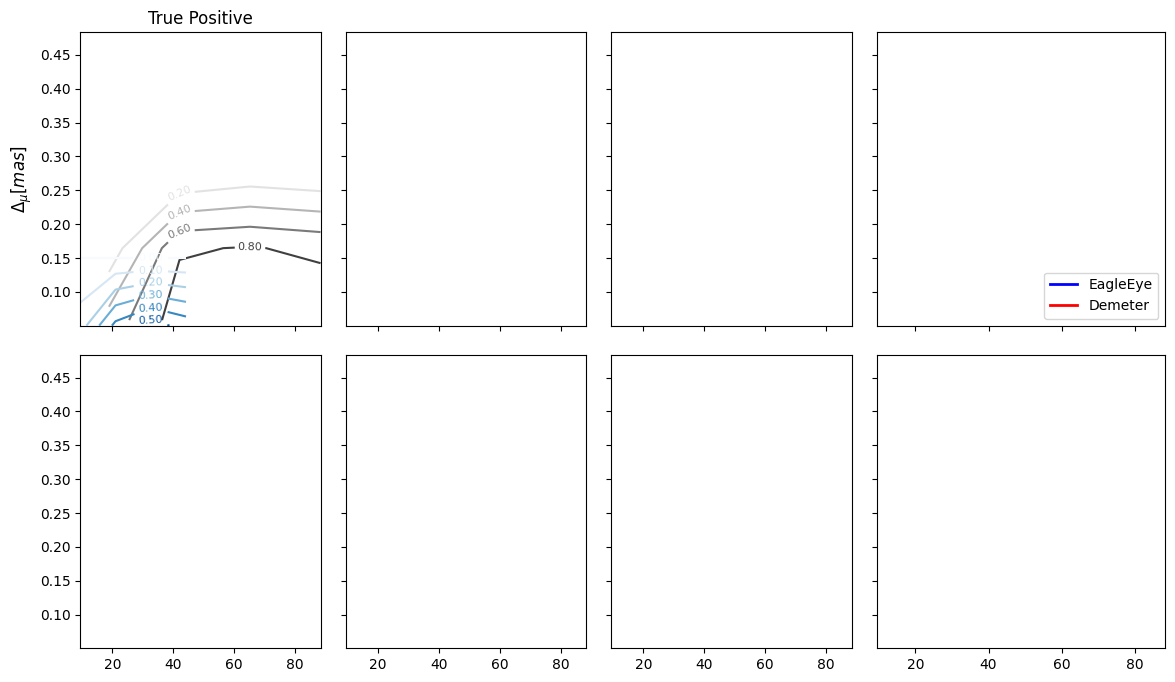

In [122]:
xbins = 4
ybins = 5#[5e-5,1e-4,5e-4,1e-3,8e-3, 5e-2,0.1]

factor = [1, 2]
# Graficar con contourf
fig,ax = plt.subplots(2,4, sharey = True, sharex = True, figsize = (14,8), 
                      gridspec_kw={'width_ratios':[1,1,1,1.2], 'hspace':0.1, 'wspace':0.1})


cmaps = ['Greys','Blues']
for i, stats in enumerate([stats14, stats28]):
    
    demeter_sig, x_edge, y_edge, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,10], statistic='mean', bins=[xbins,ybins])
    demeter_TP, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,11], statistic='mean', bins=[x_edge, y_edge])
    demeter_FP, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,14], statistic='mean', bins=[x_edge, y_edge])
    demeter_TN, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,13], statistic='mean', bins=[x_edge, y_edge])
    demeter_FN, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,12], statistic='mean', bins=[x_edge, y_edge])
    
    EE_sig, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,8], statistic='mean', bins=[x_edge, y_edge])
    EE_TP, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,4], statistic='mean', bins=[x_edge, y_edge])
    EE_FP, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,7], statistic='mean', bins=[x_edge, y_edge])
    EE_TN, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,6], statistic='mean', bins=[x_edge, y_edge])
    EE_FN, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], stats[:,5], statistic='mean', bins=[x_edge, y_edge])
    s_sb = stats[:,4] / np.sqrt(stats[:,7])
    s_sb = np.nan_to_num(s_sb,nan=0.0, posinf=100)
    pur = stats[:,4] / (stats[:,7] + stats[:,4]) 
    pur = np.nan_to_num(pur,nan=0.0, posinf=1)
    
    EE_S_SB, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], s_sb, statistic='mean', bins=[x_edge, y_edge])
    EE_PUR, _, _, binnumber = binned_statistic_2d(stats[:,0] / factor[i], stats[:,1], pur, statistic='mean', bins=[x_edge, y_edge])
    
    # Crear coordenadas del centro de los bins para el plot
    x_centers = (x_edge[:-1] + x_edge[1:]) / 2
    y_centers = (y_edge[:-1] + y_edge[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers, indexing='ij')

    #if i == 0: TP1 = ax[0,0].contourf(X, Y, EE_TP, levels=5, cmap = 'Blues')
    contour_EE = ax[0,0].contour(X, Y, EE_PUR, levels=5, cmap=cmaps[i])
    ax[0,0].clabel(contour_EE, inline=True, fontsize=8, fmt="%.2f")
    ax[0,0].set_ylabel('$\\Delta_{\\alpha} [°]$', fontsize = 12)
    ax[0,0].set_ylabel('$\\Delta_{\\mu} [mas]$', fontsize = 12)
    ax[0,0].set_title('True Positive', fontsize = 12)
    
    #contour_EE = ax[0,1].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
    #FP1 = ax[0,1].contour(X, Y, EE_FP, levels=3, colors = 'blue')
    #ax[0,1].clabel(FP1, inline=True, fontsize=8, fmt="%.2f")
    #ax[0,1].set_title('False Positive', fontsize = 12)
    
    #contour_EE = ax[0,2].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
    #TN1 = ax[0,2].contour(X, Y, EE_TN, levels=4, colors = 'blue')
    #ax[0,2].clabel(TN1, inline=True, fontsize=8, fmt="%.2f")
    #ax[0,2].set_title('True Negative', fontsize = 12)
    
    #contour_EE = ax[0,3].contourf(X, Y, EE_sig, levels=5, cmap='Greys')
    #FN1 = ax[0,3].contour(X, Y, EE_FN, levels=3, colors = 'blue')
    #ax[0,3].clabel(FN1, inline=True, fontsize=8, fmt="%.2f")
    #ax[0,3].set_title('False Negative', fontsize = 12)
    
    #cbar = plt.colorbar(contour_EE)
    #cbar.set_label('$S/(S + B)$')
    
    #contour = ax[1,0].contourf(X, Y, demeter_sig, levels=[0,10,50,150,270], cmap='Greys')
    #CS=ax[1,0].contour(X, Y, demeter_TP, levels=[0,10,15,20,50], colors = 'red')
    #ax[1,0].clabel(CS, inline=True, fontsize=8, fmt="%.2f")
    #ax[1,0].set_xlabel('# Dwarf', fontsize = 12)
    #ax[1,0].set_ylabel('$\\Delta_{\\alpha} [°]$', fontsize = 12)
    #ax[1,0].set_ylabel('$\\Delta_{\\mu} [mas]$', fontsize = 12)
    
    #contour = ax[1,1].contourf(X, Y, demeter_sig, levels=[0,10,50,150,270], cmap='Greys')
    #FP=ax[1,1].contour(X, Y, demeter_FP, levels=3, colors = 'red')
    #ax[1,1].clabel(FP, inline=True, fontsize=8, fmt="%.2f")
    #ax[1,1].set_xlabel('# Dwarf', fontsize = 12)
    
    #contour = ax[1,2].contourf(X, Y, demeter_sig, levels=[0,10,50,150,270], cmap='Greys')
    #TN=ax[1,2].contour(X, Y, demeter_TN, levels=4, colors = 'red')
    #ax[1,2].clabel(TN, inline=True, fontsize=8, fmt="%.2f")
    #ax[1,2].set_xlabel('# Dwarf', fontsize = 12)
    
    #contour = ax[1,3].contourf(X, Y, demeter_sig, levels=[0,10,50,150,270], cmap='Greys')
    #FN=ax[1,3].contour(X, Y, demeter_FN, levels=3, colors = 'red')
    #ax[1,3].clabel(FN, inline=True, fontsize=8, fmt="%.2f")
    #ax[1,3].set_xlabel('# Dwarf', fontsize = 12)
    
    #cbar = plt.colorbar(contour)
    #cbar.set_label('$\\sigma_{DEM}$')

#ax[1,1].set_ylim(0.03, 0.3)

custom_lines = [
    Line2D([0], [0], color='blue', lw=2, linestyle='solid'),
    Line2D([0], [0], color='red', lw=2, linestyle='solid')
]

# Añadir leyenda personalizada
ax[0,3].legend(custom_lines, ['EagleEye', 'Demeter'], loc = 'lower right')

#plt.savefig('../graph/GaussianAnalysis_S_SB_2.8k.pdf', bbox_inches = 'tight')

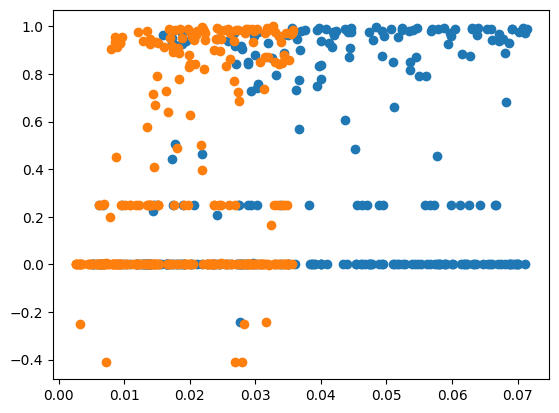

In [129]:
plt.scatter((stats14[:,0]) / 1400, stats14[:,8])
plt.scatter((stats28[:,0]) / 2800, stats28[:,8])

## Individual analysis

In [389]:
i = 15
result_dict_list = EE_results[i]
EE_book_list = EE_books[i]
clusters_list = EE_clusters[i]
blobs = blobs_list[i]
significance = significance_list[i]
clusters_demeter = clusters_demeter_list[i]
data_dwarf = dwarf_list[i]
full_field = np.c_[data_dwarf['ra'], data_dwarf['dec'], data_dwarf['pmra'], data_dwarf['pmdec']]
dwarf = full_field[-int(combinaciones[i][0]):]
print(combinaciones[i])
print(significance)

(75.12108608811243, 0.00332049142111095, 0.024802262630601132)
[36.4528923034668, 9.022558212280273]


In [390]:
references = ref_bu

In [391]:
from collections import Counter

# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq = np.zeros(len(full_field))
for i in range(len(full_field)):
    try:
        freq[i] = index_count[i]
    except:
        pass

# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list_pos[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq_pos = np.zeros(len(full_field))
for i in range(len(full_field)):
    try:
        freq_pos[i] = index_count[i]
    except:
        pass

# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list_vel[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq_vel = np.zeros(len(full_field))
for i in range(len(full_field)):
    try:
        freq_vel[i] = index_count[i]
    except:
        pass

In [392]:
aux_ind = []
cluster_array = np.asarray(clusters_demeter[0])
data_dwarf_array = np.asarray(data_dwarf)
for i in range(len(cluster_array)):
    aux_ind.append(np.where( (cluster_array[i,2] == data_dwarf_array[:,2]) &
             (cluster_array[i,3] == data_dwarf_array[:,3]) &
             (cluster_array[i,4] == data_dwarf_array[:,4]) &
             (cluster_array[i,5] == data_dwarf_array[:,5]))[0][0])

aux_ind = np.asarray(aux_ind)

In [393]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


Rep


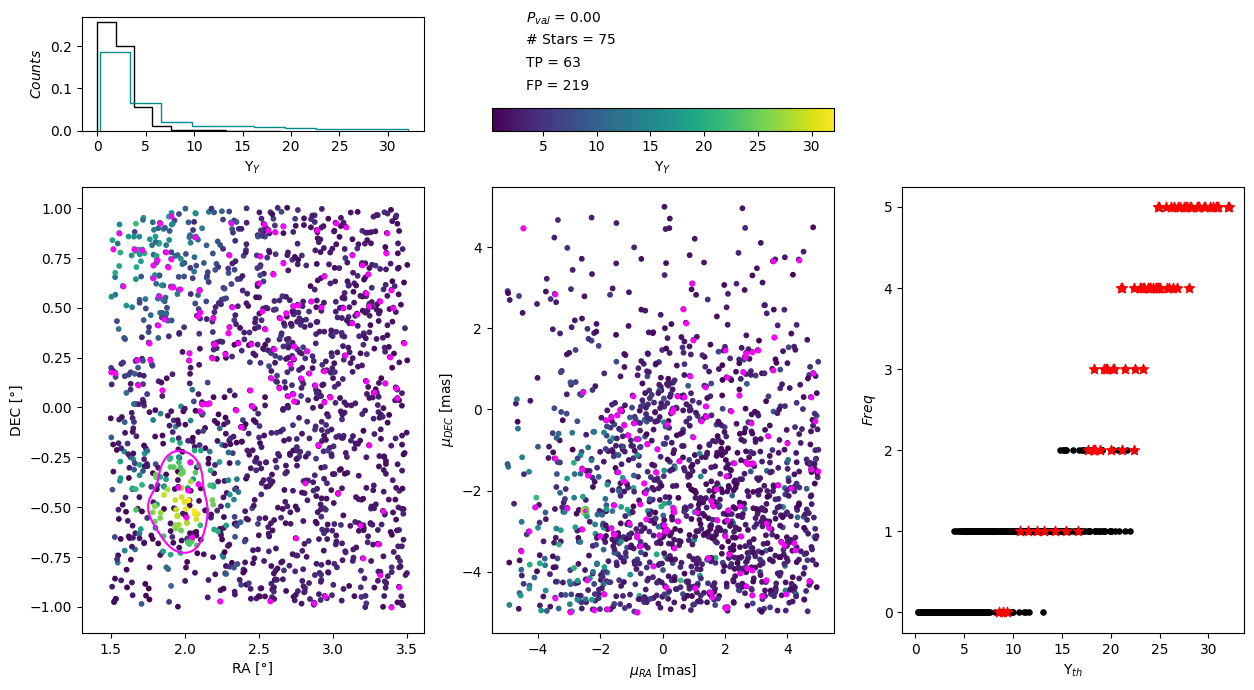

In [394]:
nups = 100
iref = 4
upsilon = result_dict_list[iref]['Upsilon_i_Y']
upsilon_x = result_dict_list[iref]['Upsilon_i_X']


upsilon_list = []
upsilonNull_list = []
for i in range(len(result_dict_list)):
    upsilon = result_dict_list[i]['Upsilon_i_Y']
    upsilon_list.append(upsilon)
    upsilonNull_list.append(result_dict_list[i]['stats_null'][list(result_dict_list[i]['stats_null'].keys())[0]])
upsilon = np.mean(np.asarray(upsilon_list),axis = 0)

up_th = np.max(np.asarray(upsilonNull_list)) #np.quantile(upsilon, 0.99)

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[1,1,1], 'height_ratios':[0.51,2]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (15,8))

try:
    overdensity_ind = np.asarray(EE_book_list[iref]['Y_OVER_clusters'][0]['Repechaged'])
    if len(overdensity_ind) == 0:
        overdensity_ind = np.asarray(np.where(upsilon >= up_th)[0])
        #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
        ax[1,2].axvline(x = up_th)
        print('Th')
    else:
        print('Rep')
except:        
    overdensity_ind = np.asarray(np.where(upsilon >= up_th)[0])
    #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
    ax[1,2].axvline(x = up_th)
    print('Th')
    
bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)

TP = len(np.where(overdensity_ind >= (len(full_field) - len(dwarf)))[0]) # True positives
FP = len(np.where(overdensity_ind < (len(full_field) - len(dwarf)))[0]) # False positives
TN = len(np.where(bkg_ind < (len(full_field) - len(dwarf)))[0]) # True negative
FN = len(np.where(bkg_ind >= (len(full_field) - len(dwarf)))[0]) # False negative

up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)

statistic, p_value = ks_2samp(upsilon, np.random.choice(result_dict_list[iref]['stats_null'][list(result_dict_list[iref]['stats_null'].keys())[0]], size = len(upsilon)))
ax[0,0].hist(result_dict_list[iref]['stats_null'][list(result_dict_list[iref]['stats_null'].keys())[0]], 
             histtype = 'step', density = True, color = 'black')
ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan')
ax[0,1].text(0.1,0.96,'$P_{val}̣$ = ' + '{:.2f}'.format(p_value), transform = ax[0,1].transAxes)
ax[0,1].text(0.1,0.76,'# Stars = {}'.format(len(dwarf)), transform = ax[0,1].transAxes)
ax[0,1].text(0.1,0.56,'TP = {}'.format(TP), transform = ax[0,1].transAxes)
ax[0,1].text(0.1,0.36,'FP = {}'.format(FP), transform = ax[0,1].transAxes)

ax[0,1].set_axis_off()

#ax[1,0].scatter(full_field[-len(dwarf):,0], full_field[-len(dwarf):,1], color = 'orange', s = 55, marker = '*', zorder = 0)
#ax[1,0].scatter(references[iref][:,0], references[iref][:,1], color = 'black', s = 2, zorder = 0)
img = ax[1,0].scatter(full_field[:,0], full_field[:,1], c = upsilon, s = 10)
sns.kdeplot(x=full_field[-len(dwarf):,0], y=full_field[-len(dwarf):,1], color = 'magenta', fill=False, ax = ax[1,0], levels = [0.5])

ax[1,1].scatter(full_field[:,2], full_field[:,3], c = upsilon, s = 10)
#ax[1,1].scatter(references[iref][:,2], references[iref][:,3], color = 'black', s = 2, zorder = 0)
sns.kdeplot(x=full_field[-len(dwarf):,2], y=full_field[-len(dwarf):,3], color = 'magenta', fill=False, ax = ax[1,1], levels = [0.5])

aux_freq = freq #+ freq_pos #+ freq_vel
ax[1,2].scatter(upsilon, aux_freq, c = 'black', s = 55, marker = '.',zorder=0)
ax[1,2].scatter(upsilon[-len(dwarf):], aux_freq[-len(dwarf):], color = 'red', s = 55, marker = '*', zorder = 2)
#ax[1,2].scatter(upsilon[aux_ind], aux_freq[aux_ind], color = 'red', s = 85, marker = '*', zorder = 1)

ax[0,0].set_xlabel('$\\Upsilon_{Y}$')
ax[0,0].set_ylabel('$Counts$')

ax[1,0].set_xlabel('RA [°]')
ax[1,0].set_ylabel('DEC [°]')

ax[1,1].set_xlabel('$\\mu_{RA }$ [mas]')
ax[1,1].set_ylabel('$\\mu_{DEC}$ [mas]')

ax[1,2].set_xlabel('$\\Upsilon_{Y}$')
ax[1,2].set_ylabel('$Freq$')

ax[0,2].set_axis_off()

ax[1,2].set_xlabel('$\\Upsilon_{th}$')

cax = inset_axes(ax[0,1],
                 width="100%",
                 height="20%",
                 loc='lower left',
                 borderpad=0)

cbar = plt.colorbar(img, cax=cax, orientation = 'horizontal')
cbar.set_label('$\\Upsilon_{Y}$')

for iref in range(len(references)):
    ind_IDE = result_dict_list[iref]['Y_underscore^+']
    ax[1,0].scatter(full_field[ind_IDE,0], full_field[ind_IDE,1], c = 'magenta', s = 10)
    ax[1,1].scatter(full_field[ind_IDE,2], full_field[ind_IDE,3], c = 'magenta', s = 10)

Rep
Rep
Rep
Rep
Rep


Text(0.5, 1.0, '$\\Upsilon_{Y}$')

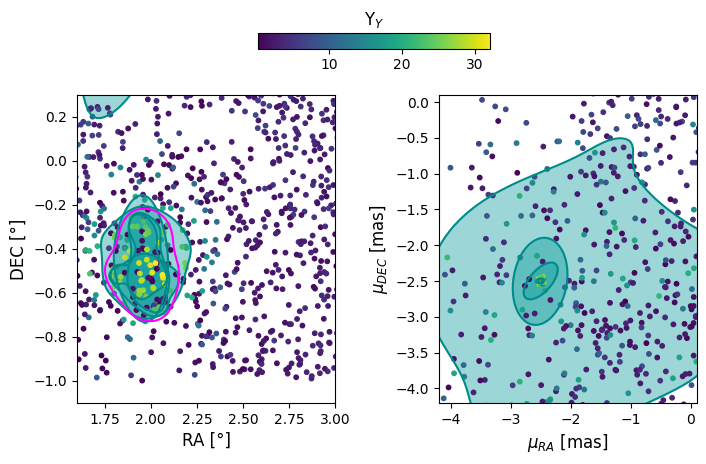

In [395]:
nups = 100
iref = 1
upsilon = result_dict_list[iref]['Upsilon_i_Y']
upsilon_x = result_dict_list[iref]['Upsilon_i_X']


upsilon_list = []
for i in range(len(result_dict_list)):
    upsilon = result_dict_list[i]['Upsilon_i_Y']
    upsilon_list.append(upsilon)
upsilon = np.mean(np.asarray(upsilon_list),axis = 0)

fig,ax = plt.subplots(1,2,
                      gridspec_kw = {'wspace':0.4},
                     #sharex = 'col', sharey = 'row',
                      figsize = (8,4))

for iref in range(len(references)):
    try:
        overdensity_ind = np.asarray(EE_book_list[iref]['Y_OVER_clusters'][0]['Repechaged'])
        if len(overdensity_ind) == 0:
            overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
            #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
            #ax[1,2].axvline(x = np.quantile(upsilon, 0.8))
            print('Th')
        else:
            print('Rep')
    except:        
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
        #ax[1,2].axvline(x = np.quantile(upsilon, 0.8))
        print('Th')
    sns.kdeplot(x=full_field[overdensity_ind,0], y=full_field[overdensity_ind,1], color = 'darkcyan', fill=True, ax = ax[0], levels = [0.5,1], alpha = 0.4, zorder = 0)
    sns.kdeplot(x=full_field[overdensity_ind,0], y=full_field[overdensity_ind,1], color = 'darkcyan', fill=False, ax = ax[0], levels = [0.5])
    sns.kdeplot(x=full_field[overdensity_ind,2], y=full_field[overdensity_ind,3], color = 'darkcyan', fill=True, ax = ax[1], levels = [0.5,1], alpha = 0.4, zorder = 0)
    sns.kdeplot(x=full_field[overdensity_ind,2], y=full_field[overdensity_ind,3], color = 'darkcyan', fill=False, ax = ax[1], levels = [0.5])

img = ax[0].scatter(full_field[:,0], full_field[:,1], c = upsilon, s = 10)
ax[1].scatter(full_field[:,2], full_field[:,3], c = upsilon, s = 10)
sns.kdeplot(x=full_field[-len(dwarf):,0], y=full_field[-len(dwarf):,1], color = 'magenta', fill=False, ax = ax[0], levels = [0.5])

ax[0].set_xlabel('RA [°]', fontsize = 12)
ax[0].set_ylabel('DEC [°]', fontsize = 12)
ax[0].set_xlim(1.6,3)
ax[0].set_ylim(-1.1,0.3)

ax[1].set_xlabel('$\\mu_{RA }$ [mas]', fontsize = 12)
ax[1].set_ylabel('$\\mu_{DEC}$ [mas]', fontsize = 12)
ax[1].set_xlim(-4.2,0.1)
ax[1].set_ylim(-4.2,0.1)

cax = ax[0].inset_axes([0.70,1.15, 0.9,0.05])

cbar = plt.colorbar(img, cax=cax, orientation = 'horizontal')
cbar.ax.set_title('$\\Upsilon_{Y}$')

#plt.savefig('../graph/GaussianIndividualAnalysis.pdf', bbox_inches = 'tight')

# Gaia Example

In [396]:
Gaia.ROW_LIMIT = -1  # Ensure the default row limit.

# Let's download a field
coord = SkyCoord(l=101, b=-61, unit=(u.degree, u.degree), frame='galactic')
data_download = Gaia.query_object_async(coord, width=u.Quantity(2.5, u.deg), height=u.Quantity(2.5, u.deg))

INFO: Query finished. [astroquery.utils.tap.core]


In [85]:
data_download.colnames

['dist',
 'solution_id',
 'DESIGNATION',
 'SOURCE_ID',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pm',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'nu_eff_used_in_astrometry',
 'pseudocolour',
 'pseudocolour_error',
 'ra_pseudocolour_corr',
 'dec_pseudocolour_corr',
 'parallax_pseudocolour_corr',
 'pmra_pseudocolour_corr',
 'pmdec_pseudocolour_corr',
 'astrometric_matched_transits',
 'visibility_periods_used',
 'astrometric_si

In [124]:
ind = np.where( 
            #(data_download['phot_g_mean_mag'] < 20) &
            #(data_download['logg_gspphot_lower'] > 4) &
            #(data_download['non_single_star'] == 0) &
            #(data_download['in_qso_candidates'] == False) &
            #(data_download['in_galaxy_candidates'] == False) &
            #(data_download['in_andromeda_survey'] == False) &
            (np.abs(data_download['pmra']) < 5) &
            (np.abs(data_download['pmdec']) < 5) &
            #(data_download['ruwe'] < 1.4) 
            ((data_download['parallax'] - 3 * data_download['parallax_error']) > 0.) # From data paper
              )[0]
print(len(ind))

816


In [102]:
len(data_download)

19205

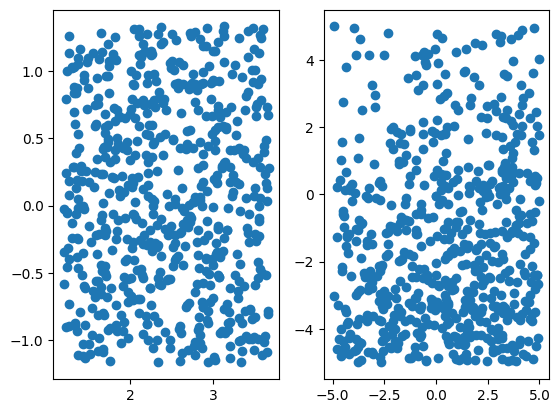

In [119]:
fig,ax = plt.subplots(1,2)

ax[0].scatter(data_download['ra'][ind],data_download['dec'][ind])
ax[1].scatter(data_download['pmra'][ind],data_download['pmdec'][ind])

(-0.1, 0.1)

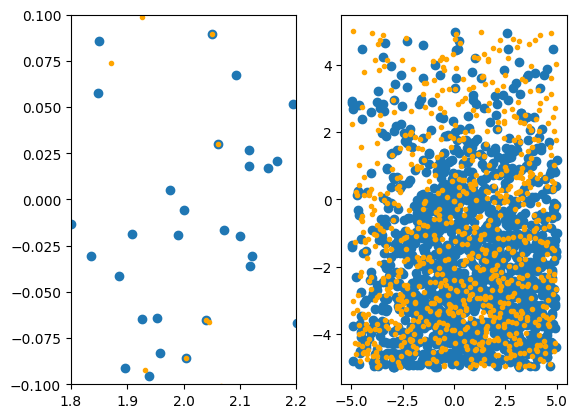

In [127]:
fig,ax = plt.subplots(1,2)

ax[0].scatter(data['ra'],data['dec'])
ax[1].scatter(data['pmra'],data['pmdec'])


ax[0].scatter(data_download['ra'][ind],data_download['dec'][ind], marker = '.', color = 'orange')
ax[1].scatter(data_download['pmra'][ind],data_download['pmdec'][ind], marker = '.', color = 'orange')

ax[0].set_xlim(1.8,2.2)
ax[0].set_ylim(-0.1,0.1)

In [69]:
data

Unnamed: 0     source_id       dec        ra      pmra     pmdec  \
37              42  2.550000e+18  0.074588  3.296455  4.538140 -4.682032   
40              46  2.550000e+18  0.075540  3.275632  0.325274  0.017531   
78              89  2.550000e+18  0.067882  3.229371 -3.075612  1.353091   
108            123  2.550000e+18  0.142795  3.066461  0.760190 -4.236989   
170            200  2.550000e+18  0.120723  3.352899 -4.295684 -3.004071   
...            ...           ...       ...       ...       ...       ...   
118817      146274  2.550000e+18 -0.656807  1.694752  0.279458 -3.037227   
118822      146280  2.550000e+18 -0.144494  1.673592  0.321831 -0.007680   
118824      146282  2.550000e+18 -0.667702  1.978566  2.455878  1.135763   
118847      146314  2.550000e+18 -0.656392  2.017616 -0.507620 -1.987260   
118853      146323  2.550000e+18 -0.329695  1.784699  4.659828  0.762275   

        pmra_error  pmdec_error  parallax  parallax_error  ...      bp_g  \
37        0.804289     0.586055  1.070484        0.435474  ...  0.779499   
40        0.469978     0.345326 -0.075753        0.271502  ...  0.089880   
78        0.437147     0.329302  0.601489        0.261869  ...  0.318861   
108       1.480636     1.271078  1.562208        1.437504  ...  0.610376   
170       1.179903     0.845002  1.227527        0.628733  ...  0.839417   
...            ...          ...       ...             ...  ...       ...   
118817    1.639414     1.215185 -0.619960        0.967902  ...  0.108765   
118822    0.329665     0.231052  0.163842        0.206033  ...  0.490479   
118824    1.420430     1.211753  0.840577        0.833210  ... -0.036123   
118847    1.936172     1.722856  4.134361        1.631514  ... -0.105679   
118853    0.213817     0.158920  0.199719        0.145238  ...  0.345409   

           bp_rp  phot_g_mean_flux  phot_g_mean_flux_error  phot_bp_mean_mag  \
37      1.764843        338.632394                1.269772         20.143543   
40      0.528816        768.036233                2.587946         18.564790   
78      0.926615        704.080055                1.690934         18.888172   
108     1.715364        153.519763                0.962133         20.833332   
170     2.012388        224.091337                1.157139         20.651720   
...          ...               ...                     ...               ...   
118817  0.881233        147.821048                0.960055         20.372790   
118822  1.139921       2017.177503                2.335725         17.916985   
118824  0.585445        198.716485                1.963485         19.906658   
118847  0.673349        119.928938                1.484086         20.385378   
118853  0.858009       3320.032103                3.075083         17.230919   

        phot_bp_mean_flux  phot_bp_mean_flux_error  phot_rp_mean_mag  \
37             121.098316                 7.283483         18.378700   
40             518.369356                17.455944         18.035975   
78             384.845546                 8.034848         17.961557   
108             64.153861                 6.410905         19.117968   
170             75.834512                 7.728439         18.639332   
...                   ...                      ...               ...   
118817          98.048228                 7.906543         19.491556   
118822         941.372100                12.903549         16.777063   
118824         150.623318                15.399403         19.321213   
118847          96.917888                 8.046745         19.712029   
118853        1770.874445                13.707850         16.372910   

        phot_rp_mean_flux  phot_rp_mean_flux_error  
37             357.509642                 6.303470  
40             490.205798                 6.849401  
78             524.982880                11.955410  
108            180.959454                 8.600692  
170            281.213003                11.245334  
...                   ...             

In [59]:
ff = full_field

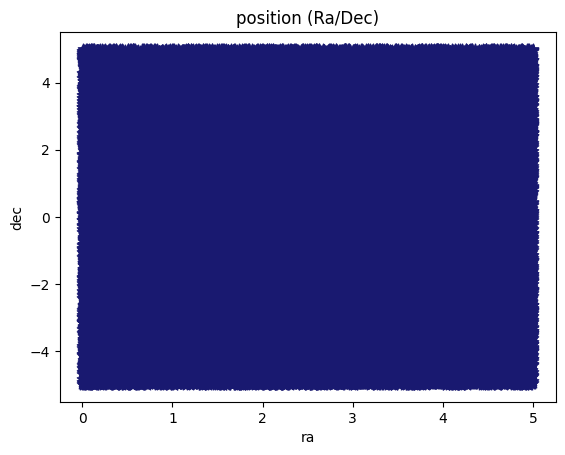

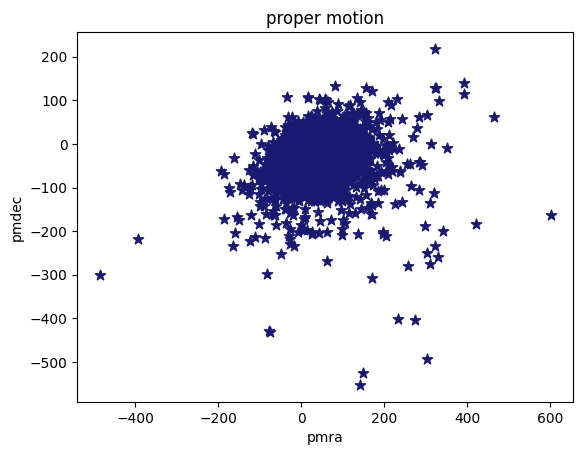

Text(0.5, 1.0, 'parallax')

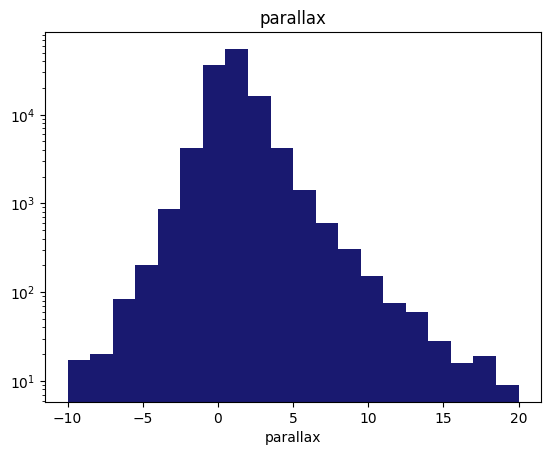

In [81]:
#load example gaia data and plot distributions 

data = pd.read_csv('demeter/data/gaia_example_data.csv')

plt.scatter(data['ra'], data['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('position (Ra/Dec)')

plt.show()

plt.scatter(data['pmra'], data['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.title('proper motion')

plt.show()

parallax = data['parallax']

plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
plt.yscale('log')
plt.xlabel('parallax')
plt.title('parallax')


In [82]:
#center of the sky field in RA and DEC 
median_ra = 2.5
median_dec = 0


#width of the field in gnomonic coordinates 
gnomonic_width = 0.0175

#width of the proper motion field 
pmfield_size = 5.0 

In [83]:
#apply position, proper motion, and parallax cuts 
data1 = data 
data, x, y = demeter.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)

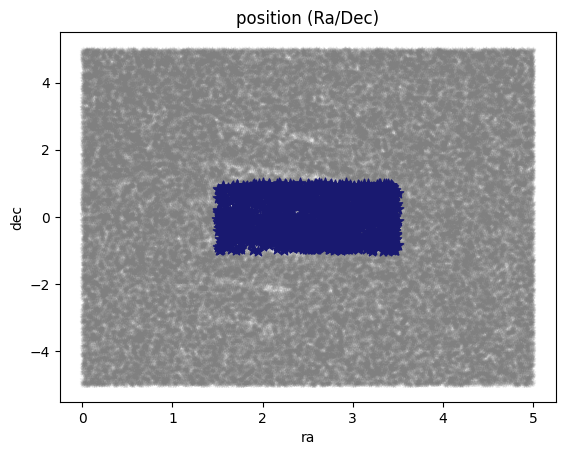

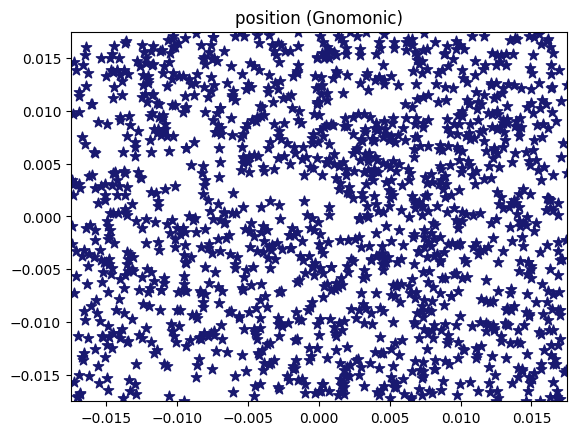

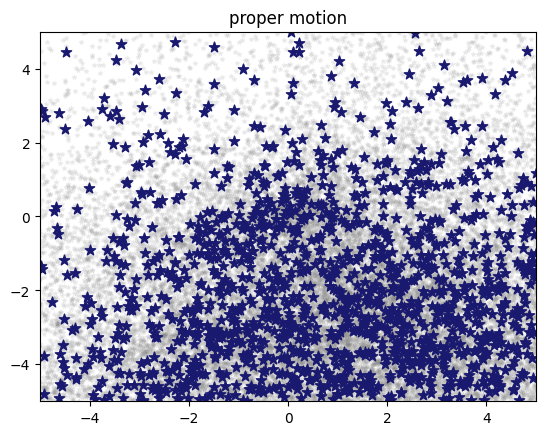

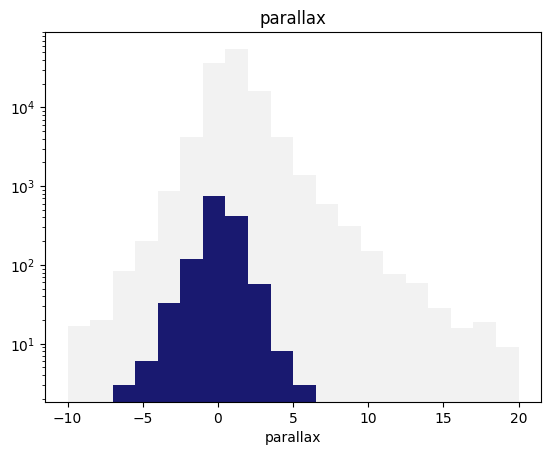

In [84]:
#check masking and gnomonic projection 
plt.scatter(data1['ra'], data1['dec'], c='grey',alpha=0.1, s=10,marker='*')
plt.scatter(data['ra'], data['dec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('position (Ra/Dec)')
plt.show()


plt.scatter(x,y, c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position (Gnomonic)')


plt.show()
plt.scatter(data1['pmra'], data1['pmdec'], c='grey',alpha=0.1, s=10,marker='*')
plt.scatter(data['pmra'], data['pmdec'], c='midnightblue',alpha=1.,marker='*',s=60)
plt.xlim([-pmfield_size,pmfield_size])
plt.ylim([-pmfield_size,pmfield_size])
plt.title('proper motion')

plt.show()

parallax = data['parallax']
plt.hist(data1['parallax'], bins = 20, range=(-10, 20), color='grey',alpha=0.1)
plt.hist(parallax, bins = 20, range=(-10, 20), color='midnightblue')
plt.yscale('log')
plt.xlabel('parallax')
plt.title('parallax')

plt.show()

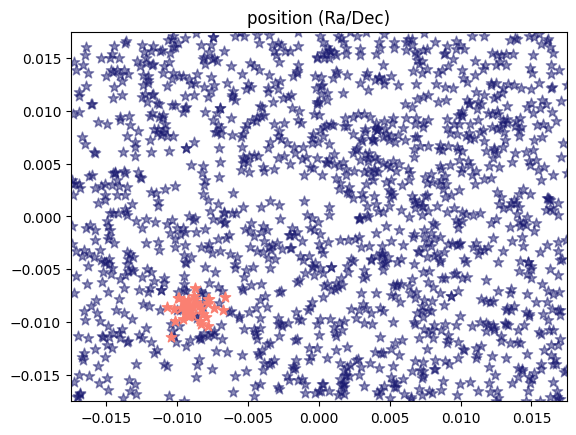

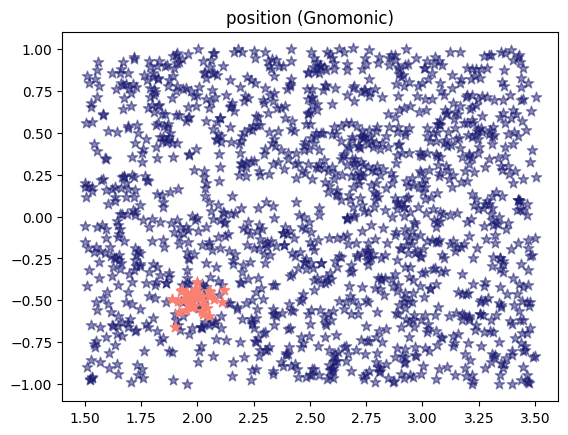

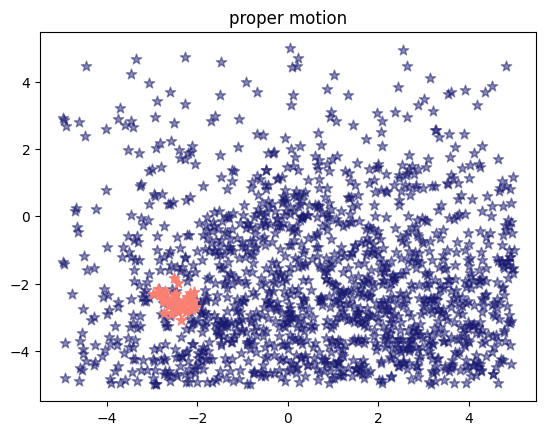

In [85]:
#test pipeline for simple gaussian "mock injection" 

#generate mock data 
xx = normal(-gnomonic_width/2, gnomonic_width/20, 20)
yy = normal(-gnomonic_width/2, gnomonic_width/20, 20)
pmra = normal(-pmfield_size/2, pmfield_size/20, 20)
pmdec = normal(-pmfield_size/2, pmfield_size/20, 20)

plt.scatter(x,y, c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(xx,yy, c='salmon',alpha=1.,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position (Ra/Dec)')

plt.show()

#transform data to Ra/Dec  
ra_inj, dec_inj = demeter.from_gnomonic(xx,yy,median_ra,median_dec)
plt.scatter(data['ra'],data['dec'],c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(ra_inj, dec_inj, c='salmon',alpha=1.,marker='*',s=60)
plt.title('position (Gnomonic)')

plt.show()

plt.scatter(data['pmra'],data['pmdec'],c='midnightblue',alpha=.5,marker='*',s=60)
plt.scatter(pmra, pmdec,  c='salmon',alpha=1.,marker='*',s=60)
plt.title('proper motion')

plt.show()

In [96]:
#inject stars into Gaia dataand re-apply masking 
df = pd.DataFrame(columns=data.keys())
for k in (data.keys()):
    df[k] = np.ones(len(xx))
df['pmra'] = pmra
df['pmdec'] = pmdec
df['ra'] = ra_inj
df['dec'] = dec_inj

data = pd.concat((data,df))
data, x, y = demeter.mask_data(data, median_ra, median_dec, gnomonic_width, pmfield_size)

0
40


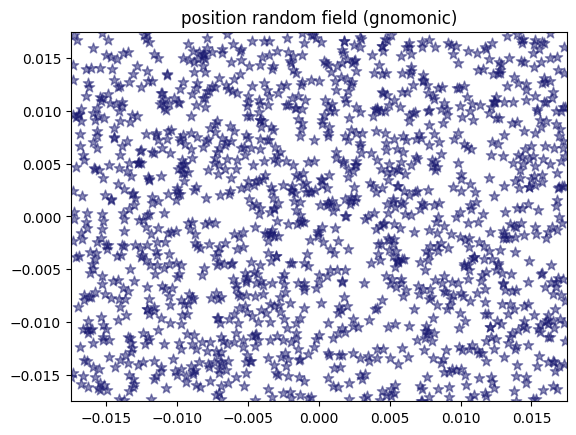

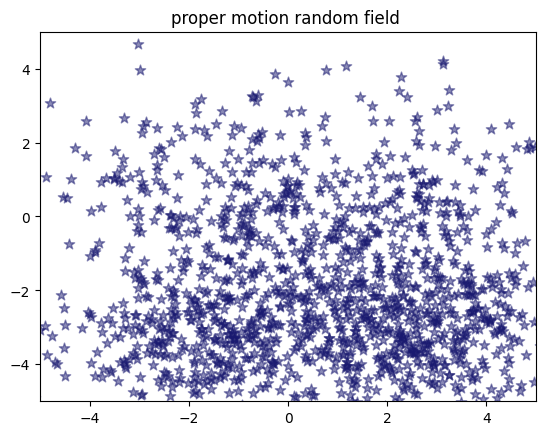

In [66]:
#generate random comparison field 

#generate random field 
rand_ra, rand_dec, rand_pmra, rand_pmdec = demeter.make_random_image(data, x, y, gnomonic_width, pmfield_size)


plt.scatter(rand_ra, rand_dec,c='midnightblue',alpha=.5,marker='*',s=60)
plt.xlim([-gnomonic_width,gnomonic_width])
plt.ylim([-gnomonic_width,gnomonic_width])
plt.title('position random field (gnomonic)')

plt.show()

plt.scatter(rand_pmra, rand_pmdec,c='midnightblue',alpha=.5,marker='*',s=60)

plt.title('proper motion random field ')
plt.xlim([-pmfield_size,pmfield_size])
plt.ylim([-pmfield_size,pmfield_size])
plt.show()

In [98]:
#test function to load gaia data -- reset median_ra and median_dec to
#test values around edges of survey 
#set parameters 
grid_size=96
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)

(96, 96, 96, 96)


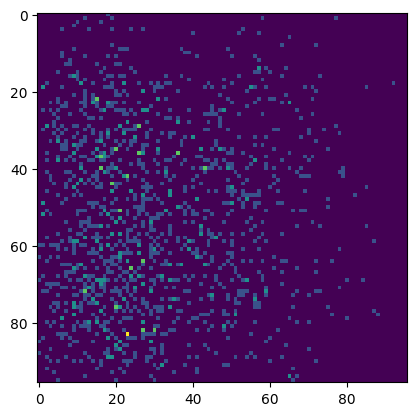

In [99]:
#generate histograms for wavelet transformation 

full_field = np.c_[x, y, data['pmra'], data['pmdec']]

random_field = np.c_[rand_ra, rand_dec, rand_pmra, rand_pmdec]

#generate histograms 
field_image, edges = demeter.make_field_image(full_field, gnomonic_width, pmfield_size, grid_size)
random_image, edges = demeter.make_field_image(random_field, gnomonic_width, pmfield_size, grid_size)

print(random_image.shape)

plt.imshow(random_image.sum(axis=(0,1)), origin='upper')
plt.show()

## Demeter

In [102]:
field_image, edges = demeter.make_field_image(full_field, gnomonic_width, pmfield_size, grid_size)

In [103]:
#plot smoothed field before transformation 
smooth_field = ndimage.filters.gaussian_filter(field_image,3.0)

/tmp/ipykernel_2048435/3693065880.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_field = ndimage.filters.gaussian_filter(field_image,3.0)


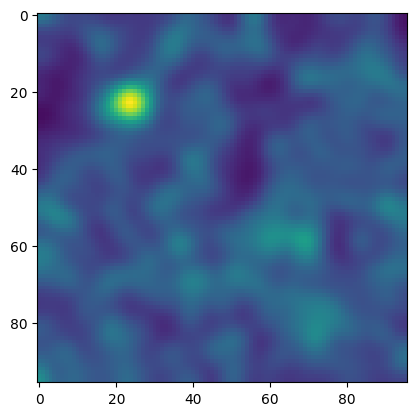

In [104]:
plt.imshow(smooth_field.sum(axis=(2,3))/np.max(smooth_field.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

print(device)

wv = demeter.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5']).to(device)
out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

cuda


In [106]:
#apply smoothing 
out = ndimage.filters.gaussian_filter(out,3.0)
rand_out = ndimage.filters.gaussian_filter(rand_out,3.0)


/tmp/ipykernel_2048435/1782558903.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  out = ndimage.filters.gaussian_filter(out,3.0)
/tmp/ipykernel_2048435/1782558903.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  rand_out = ndimage.filters.gaussian_filter(rand_out,3.0)


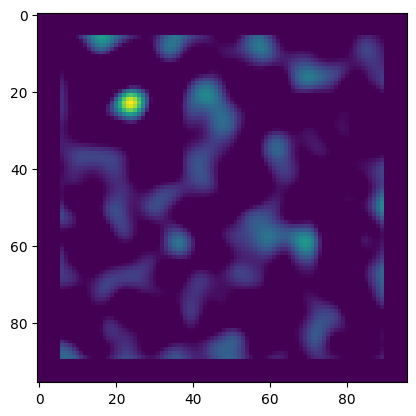

In [107]:
#remove outer edges of image 
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

plt.imshow(out1.sum(axis=(2,3))/np.max(out1.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()

In [108]:
#standardize the real output 
out = (out-np.mean(rand_out))/np.std(rand_out)

In [109]:
#apply threshold 
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)
nstars = len(data)

#apply significance correction 
out = out / (-0.6*np.log10(nstars)+4.)

#applying thresholding 
mask = out < 5.0 
out[mask] = 0

#remove outer edges of image
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

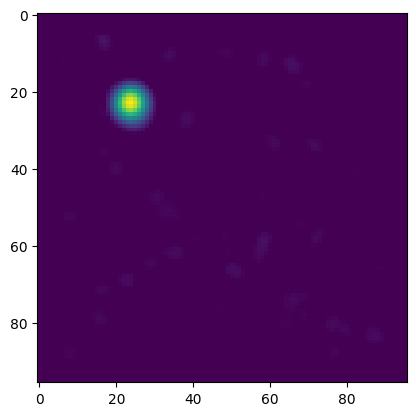

In [110]:
plt.imshow(out1.sum(axis=(2,3)))
plt.show()

In [111]:
#find remaining hotspots 
blobs, significance = demeter.find_blobs(out1, threshold=9)

In [112]:
print(blobs)
print(significance)

[[23.448519257326993, 23.94583397268682, 24.205846248273744, 23.635415068282953, 11.97695959304138, 11.31239402096031, 12.311776495640267, 11.682543535674078]]
[46.60478591918945]


In [113]:
#find clusters in original dataset 
clusters = demeter.find_clusters(data, x, y, gnomonic_width, pmfield_size, grid_size, blobs)

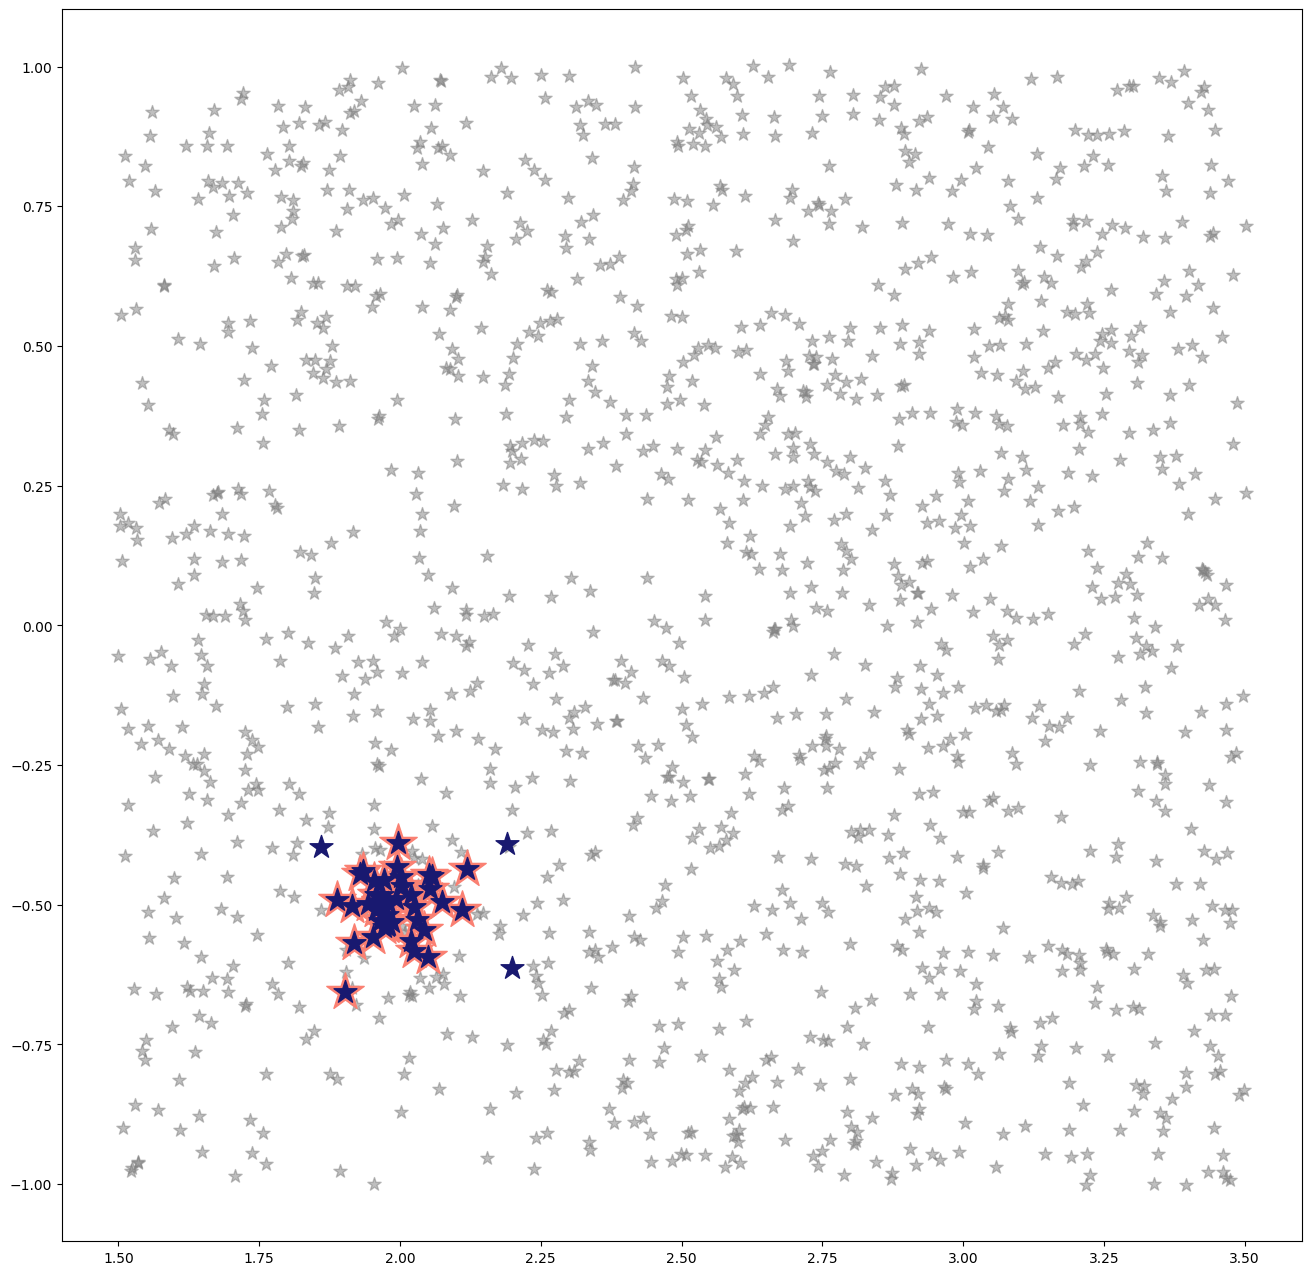

all injected stars recovered successfully!


In [114]:
fig, ax = plt.subplots(figsize=(16,16))

#plot background stars 
plt.scatter(data['ra'],data['dec'], alpha=0.5, color='grey', s=100, marker='*')

#plot injected stars 
plt.scatter(df['ra'], df['dec'], alpha=1., color='salmon',s=800, marker='*')

#plot returned stars
for cluster in clusters:
    if(len(cluster)>=5):
        plt.scatter(cluster['ra'], cluster['dec'], color='midnightblue',s=300, marker='*')

plt.show()

mask = np.isin(cluster['ra'], df['ra'])

if(len(cluster[mask]==len(df))):
    print('all injected stars recovered successfully!')

In [115]:
#calculate cluster poission significance 

#first filter field stars by cluster proper motio n
maxpmra = np.max(cluster['pmra'])
minpmra = np.min(cluster['pmra'])
maxpmdec = np.max(cluster['pmdec'])
minpmdec = np.min(cluster['pmdec'])

mask1 = data['pmra'] <= maxpmra
mask2 = data['pmra'] >= minpmra
mask3 = data['pmdec'] <= maxpmdec
mask4 = data['pmdec'] >= minpmdec
mask = mask1 & mask2 & mask3 & mask4
    
#calculate poisson rate for remaining stars 
poisson_rate = len(x[mask])
x_clust, y_clust = demeter.to_gnomonic(cluster['ra'], cluster['dec'], median_ra, median_dec) 
area = (np.pi/4*(np.max(x_clust) - np.min(x_clust))*(np.max(y_clust) - np.min(y_clust)))/(4*gnomonic_width**2)

#calculate poisson significance 
poisson_int = (np.mean(scipy.stats.poisson(poisson_rate*area).rvs(10000)))
significance_poisson = ((len(cluster)-poisson_int)/np.sqrt(poisson_int))

print('wavelet significance: ' + str(np.round(significance[0], 2)))
print('poisson significance: ' + str(np.round(significance_poisson)))

wavelet significance: 46.6
poisson significance: 34.0
